In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.model_selection import TimeSeriesSplit, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from yellowbrick.regressor import ResidualsPlot, PredictionError
from sklearn.inspection import permutation_importance

import pickle

<h1 style='text-align: center'}>Model-Selection-Training-Evaluation</h1>

## Data Scaling
In this section, I'll focus on the importance of scaling data for machine learning models. When features have different ranges or units, it can make it harder for models to learn effectively. By scaling the data, I ensure that all features are on a similar scale, which helps improve the model's performance and stability.

In [2]:
train_macro_analysed = pd.read_csv("data/processed_data/train_macro_analysed.csv")

Droping the columns that i have transformed in some way earlier in the project.

In [3]:
columns_to_drop = [
    'price_doc',
    'full_sq',
    'cafe_sum_1000_min_price_avg', 
    'cafe_sum_1500_min_price_avg', 
    'cafe_sum_500_min_price_avg', 
    'cafe_sum_2000_min_price_avg',
    'num_room',
    'sub_area',
    'id',
    'timestamp'
]

In [4]:
train_macro_analysed = train_macro_analysed.drop(columns=columns_to_drop)

In [5]:
train_macro_analysed.shape

(27786, 135)

I’ll begin by transforming categorical variables into dummy variables.

In [6]:
train_macro_analysed_dummies = pd.get_dummies(train_macro_analysed, drop_first=True)

In [7]:
train_macro_analysed_dummies.shape

(27786, 152)

Next, I will split the dataset into features and the target variable.

In [8]:
data_attributes = train_macro_analysed_dummies.drop(columns=['log_price_doc'])
data_target = train_macro_analysed_dummies['log_price_doc'] 

Extract the numerical columns and scale them with MinMaxScaler().

In [9]:
numerical_columns = data_attributes.select_dtypes(include=['int64', 'float64']).columns

In [10]:
scaler = MinMaxScaler()

In [11]:
data_attributes_scaled = scaler.fit_transform(data_attributes[numerical_columns])

In [15]:
data_attributes_scaled

array([[0.00361059, 0.05194805, 0.1025641 , ..., 0.63333333, 0.63636364,
        0.        ],
       [0.00254079, 0.03896104, 0.1025641 , ..., 0.73333333, 0.63636364,
        0.        ],
       [0.00387804, 0.02597403, 0.1025641 , ..., 0.86666667, 0.63636364,
        0.        ],
       ...,
       [0.00401177, 0.12987013, 0.17094017, ..., 0.96666667, 0.45454545,
        1.        ],
       [0.00427922, 0.06493506, 0.12820513, ..., 0.96666667, 0.45454545,
        1.        ],
       [0.00374432, 0.01298701, 0.07692308, ..., 0.96666667, 0.45454545,
        1.        ]])

## Train-Test Split

In this section, I'll focus on splitting the dataset into training and testing sets. This is a crucial step in building machine learning models, as it allows me to train the model on one portion of the data and evaluate its performance on an unseen portion to avoid overfitting.

However, since I am dealing with time-dependent data, I will use `TimeSeriesSplit` rather than the standard random split. `TimeSeriesSplit` is a cross-validation method specifically designed for time-series data, where the order of the observations matters. Unlike random splitting, this technique ensures that the model is trained on past data and tested on future data, maintaining the temporal sequence. This is particularly important for predictive modeling in scenarios like forecasting, where future data cannot be used to predict past outcomes.

In [18]:
# Visualization of the splits

tscv = TimeSeriesSplit(n_splits=4)

for fold, (train_index, test_index) in enumerate(tscv.split(data_attributes), 1):
    print(f"Fold {fold}:")
    print(f"Train size: {len(train_index)}, Test size: {len(test_index)}")
    print(f"Training data range: {train_index[0]} to {train_index[-1]}")
    print(f"Test data range: {test_index[0]} to {test_index[-1]}")
    print("-" * 40)

Fold 1:
Train size: 5558, Test size: 5557
Training data range: 0 to 5557
Test data range: 5558 to 11114
----------------------------------------
Fold 2:
Train size: 11115, Test size: 5557
Training data range: 0 to 11114
Test data range: 11115 to 16671
----------------------------------------
Fold 3:
Train size: 16672, Test size: 5557
Training data range: 0 to 16671
Test data range: 16672 to 22228
----------------------------------------
Fold 4:
Train size: 22229, Test size: 5557
Training data range: 0 to 22228
Test data range: 22229 to 27785
----------------------------------------


In [32]:
train_macro_analysed_dummies.iloc[27785].month

6

# Model Selection

In this section, I will explore and evaluate different regression models to determine which one performs best for predicting the target variable. Regression models are widely used for predicting continuous outcomes, and selecting the right model is crucial for achieving accurate results.

I will experiment with several common regression algorithms, including Linear Regression, Decision Trees, Random Forests, and Gradient Boosting. Each model will be trained and evaluated using the same dataset, and their performance will be compared based on key metrics like Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared.

By the end of this section, I aim to identify the most suitable model for this specific problem, considering both its predictive accuracy and computational efficiency.

### 1. Random Forest
I will start with the Random Forest model because it is well-suited for our dataset and offers several advantages. Our dataset contains a large number of columns (features), which could present challenges for models like Linear Regression and SVM (Support Vector Machines).

Linear Regression assumes a linear relationship between features and the target variable, which may not capture the complexity of our dataset. On the other hand, SVM is capable of handling nonlinear relationships but is computationally expensive. With a large number of features and data points, SVM can take a very long time to fit, making it less practical for our use case.

Random Forest, however, is an ensemble model that builds multiple decision trees and combines their predictions. It is efficient, flexible, and can handle nonlinear relationships with ease. Additionally, Random Forest is less sensitive to feature scaling and robust to overfitting, which makes it an excellent choice for our dataset.

As first step I want to see feauture importances.

In [65]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

tscv = TimeSeriesSplit(n_splits=4)

feature_importances = []
column_names = data_attributes.columns  

for train_index, test_index in tscv.split(data_attributes_scaled):
    X_train, X_test = data_attributes_scaled[train_index], data_attributes_scaled[test_index]
    y_train, y_test = data_target.iloc[train_index], data_target.iloc[test_index]

    rf_model.fit(X_train, y_train)

    perm_importance = permutation_importance(
        rf_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
    )
    
    feature_importances.append(perm_importance.importances_mean)

avg_importance = np.mean(feature_importances, axis=0)

In [66]:
sorted_indices = np.argsort(avg_importance)[::-1]
top_n = 10
print(f"Top {top_n} Features by Importance:")
for i in range(top_n):
    feature_name = column_names[sorted_indices[i]]
    importance = avg_importance[sorted_indices[i]]
    print(f"{i + 1}. {feature_name}: {importance:.4f}")

Top 10 Features by Importance:
1. log_full_sq: 0.7226
2. raion_build_count_with_material_info: 0.4906
3. mkad_km: 0.0431
4. green_zone_part: 0.0141
5. catering_km: 0.0059
6. kitch_sq: 0.0048
7. cafe_sum_5000_min_price_avg: 0.0038
8. indust_part: 0.0036
9. church_synagogue_km: 0.0020
10. mosque_km: 0.0020


Results with Random Forest Model:


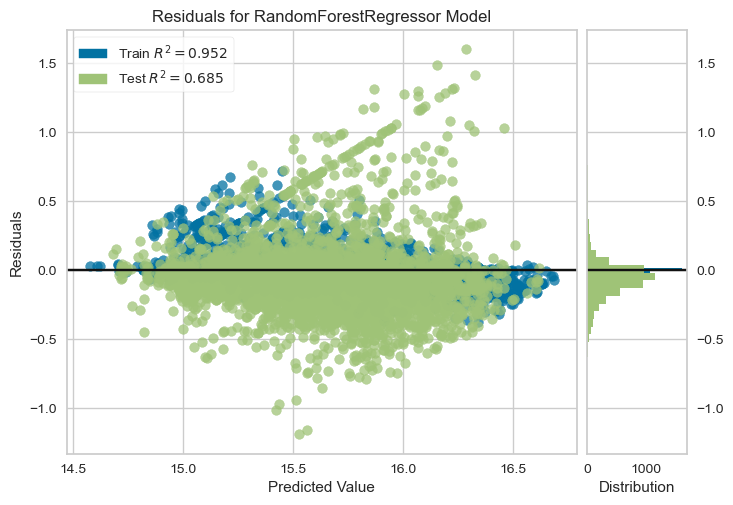

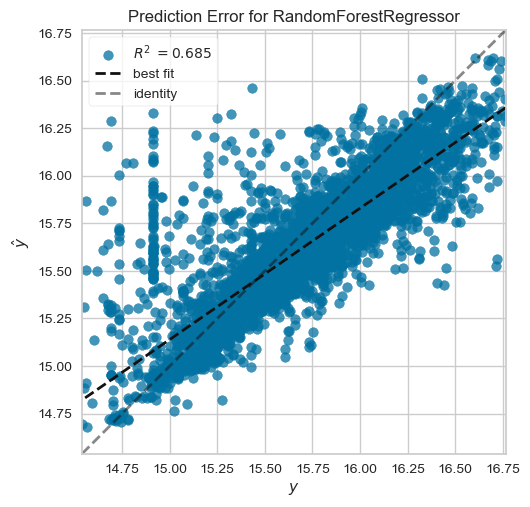

Mean Squared Error (MSE) for split [1]: 0.048656635913686526
Mean Absolute Error (MAE) for split [1]: 0.1421912777705535
----------------------------------------------------------


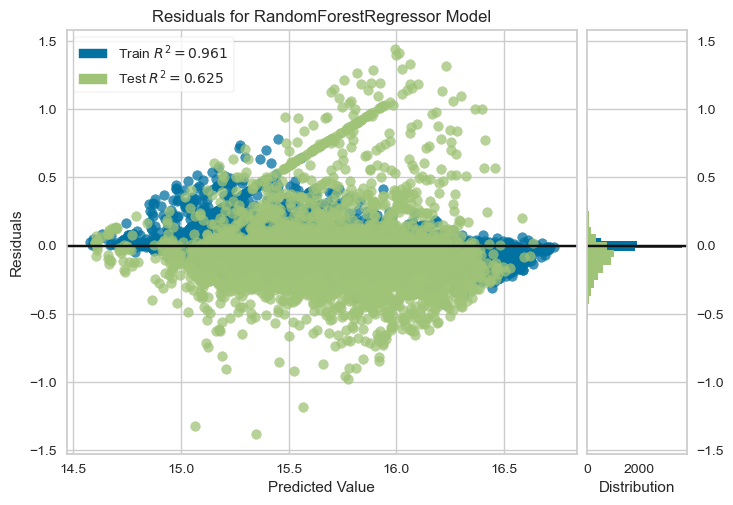

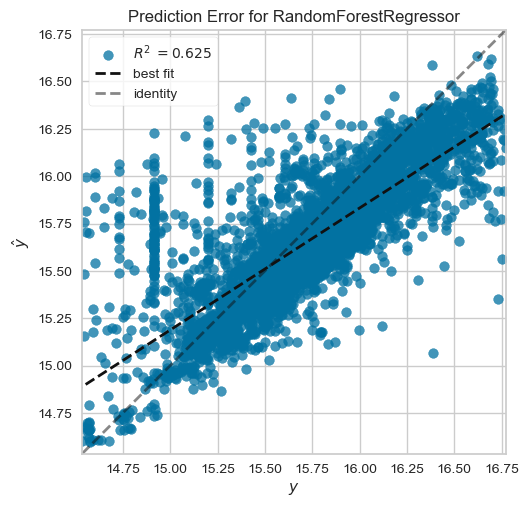

Mean Squared Error (MSE) for split [2]: 0.059127450910569306
Mean Absolute Error (MAE) for split [2]: 0.16531423109905086
----------------------------------------------------------


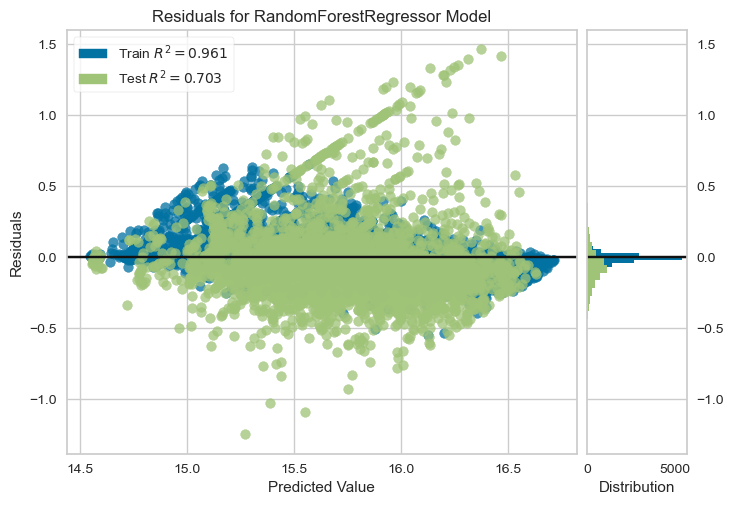

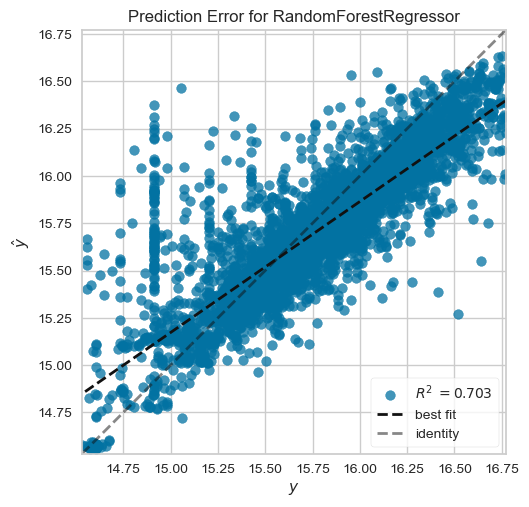

Mean Squared Error (MSE) for split [3]: 0.049130324368645686
Mean Absolute Error (MAE) for split [3]: 0.14973916499739187
----------------------------------------------------------


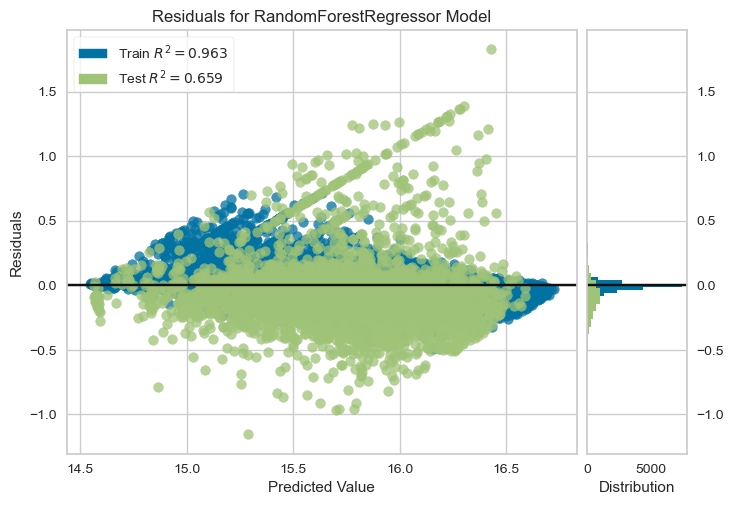

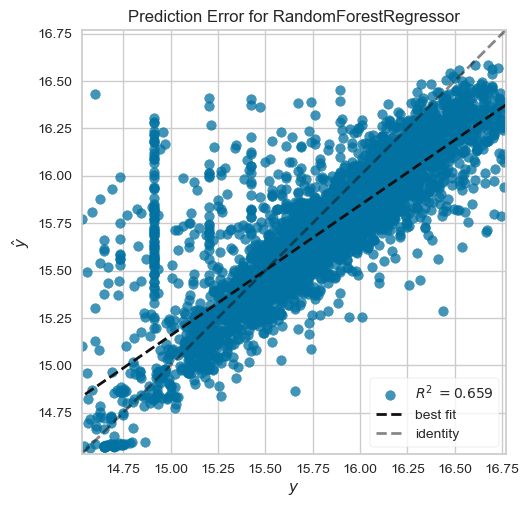

Mean Squared Error (MSE) for split [4]: 0.05820887943317851
Mean Absolute Error (MAE) for split [4]: 0.16690020754081142
----------------------------------------------------------


True Values  Predictions
0        15.856731    15.699661
1        14.845130    15.545395
2        15.964292    15.858189
3        15.152927    15.184467
4        15.978834    15.917463
...            ...          ...
22223    15.725135    15.374204
22224    15.816991    15.639482
22225    15.757264    15.488368
22226    16.418200    15.945779
22227    15.538277    15.596484

[22228 rows x 2 columns]

In [36]:
def evaluate_model_test_data(model, data_attributes_scaled, data_target, tscv):
    true_values = []
    predictions = []
    
    current_fold = 1
    
    for train_index, test_index in tscv.split(data_attributes_scaled):
        X_train, X_test = data_attributes_scaled[train_index], data_attributes_scaled[test_index]
        y_train, y_test = data_target.iloc[train_index], data_target.iloc[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        true_values.extend(y_test) 
        predictions.extend(y_pred)

        visualizer_residual = ResidualsPlot(model)
        visualizer_residual.fit(X_train, y_train)
        visualizer_residual.score(X_test, y_test)
        visualizer_residual.show()

        visualizer_prediction_error = PredictionError(model)
        visualizer_prediction_error.fit(X_train, y_train)
        visualizer_prediction_error.score(X_test, y_test)
        visualizer_prediction_error.show()

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)

        print(f"Mean Squared Error (MSE) for split [{current_fold}]: {mse}")
        print(f"Mean Absolute Error (MAE) for split [{current_fold}]: {mae}")
        current_fold += 1
        print('----------------------------------------------------------')

    return pd.DataFrame({
        'True Values': true_values,
        'Predictions': predictions
        })

tscv = TimeSeriesSplit(n_splits=4)
rf_model = RandomForestRegressor(n_estimators=100)

print("Results with Random Forest Model:")
evaluate_model_test_data(rf_model, data_attributes_scaled, data_target, tscv)

What I can say considering the results is:
1. `Low MSE Values`: The MSE values are relatively low, ranging between 0.0485 and 0.0593, indicating that the model is making accurate predictions on the test data.
2. `Consistency Across Splits`: The variation in MSE across splits is minimal, with a range of approximately 0.0108. This suggests the model is stable and generalizes well across different train-test configurations.
3. `Slight Variations in Performance`: Splits 2 and 4 show slightly higher errors, possibly due to temporal shifts or more complex patterns in the data during those periods.
4. `Low MAE Values`: The MAE values range from 0.1421 to 0.1694, reflecting relatively small average errors in prediction. This suggests that, on average, the model's predictions are close to the true values.
Residual Behavior: Residuals are centered around zero, showing no significant bias, though splits 2 and 4 exhibit slightly more scatter.

To test for overfitting, I will compare the model's performance on the training and test datasets. Overfitting occurs when the model performs well on the training data but fails to generalize to the test data, indicating that it has memorized the training set rather than learning underlying patterns. By comparing metrics like MSE and MAE for both training and test sets, and analyzing residuals, I can assess whether the model is overfitting.

Results with Default Model:


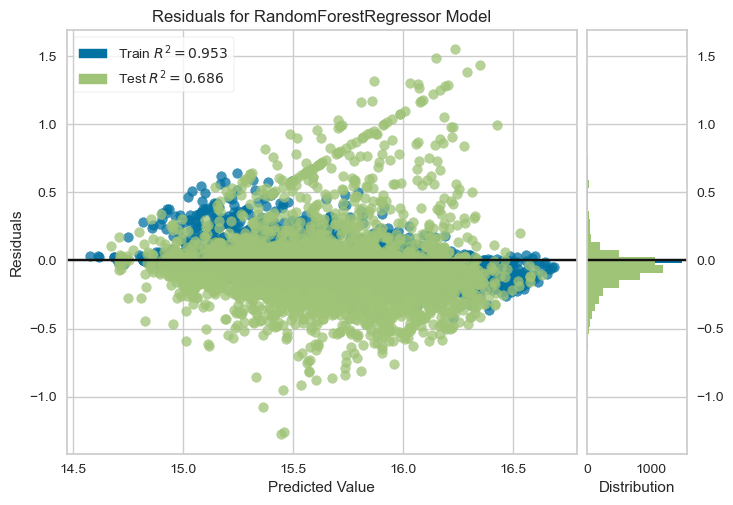

Mean Squared Error for split [1] (Test): 0.04848642048811274
Mean Squared Error for split [1] (Train): 0.007259420871027361
----------------------------------------------------------------------------
Mean Absolute Error for split [1] (Test): 0.14182909835009905
Mean Absolute Error for split [1] (Train): 0.048078787158244804




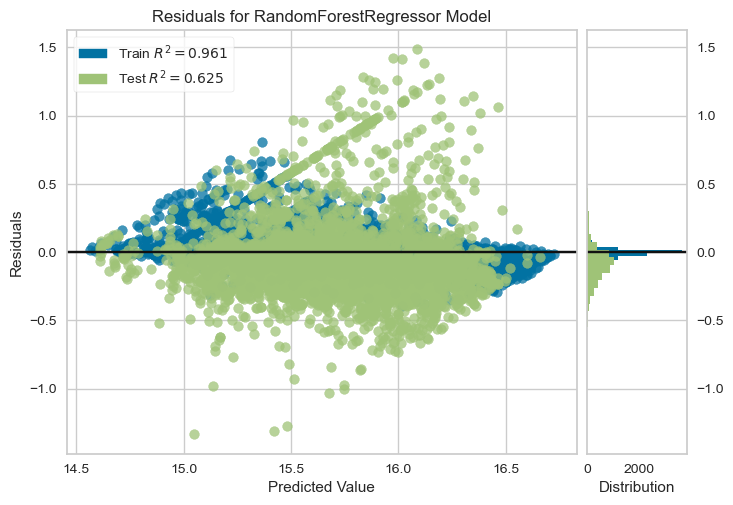

Mean Squared Error for split [2] (Test): 0.05905208624361068
Mean Squared Error for split [2] (Train): 0.0060844499155310395
----------------------------------------------------------------------------
Mean Absolute Error for split [2] (Test): 0.16504199145053444
Mean Absolute Error for split [2] (Train): 0.04285089950251888




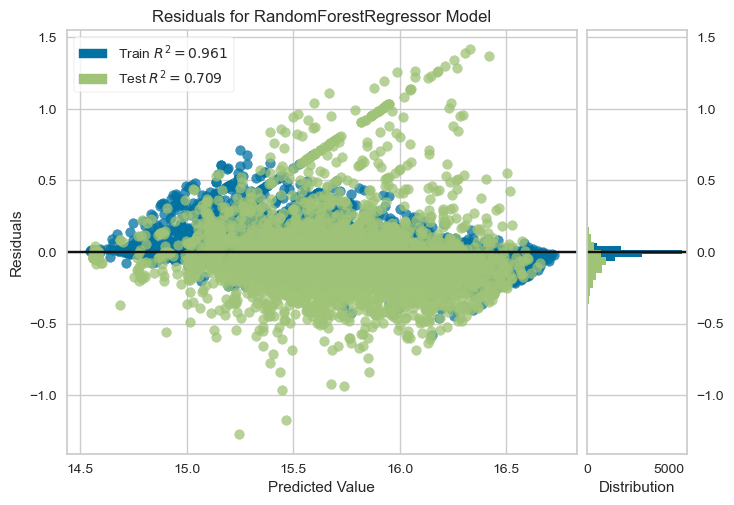

Mean Squared Error for split [3] (Test): 0.04813640957093686
Mean Squared Error for split [3] (Train): 0.006165190130040209
----------------------------------------------------------------------------
Mean Absolute Error for split [3] (Test): 0.14735152475619565
Mean Absolute Error for split [3] (Train): 0.04365938142025184




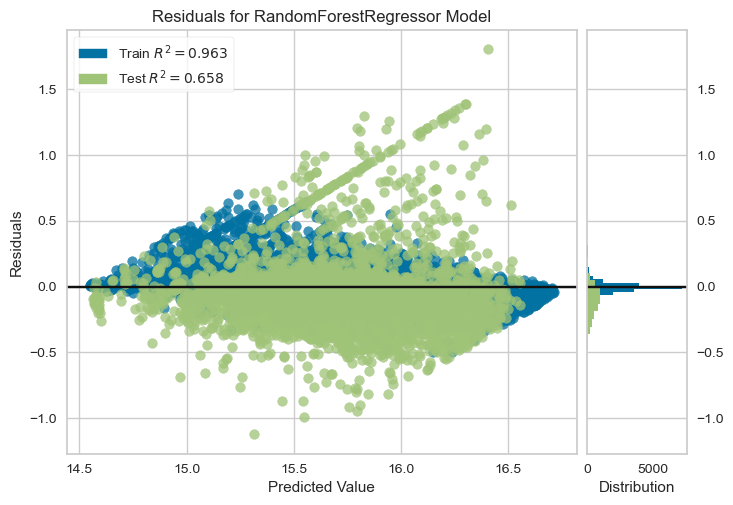

Mean Squared Error for split [4] (Test): 0.05833252342945511
Mean Squared Error for split [4] (Train): 0.006005037779728682
----------------------------------------------------------------------------
Mean Absolute Error for split [4] (Test): 0.16784805514780116
Mean Absolute Error for split [4] (Train): 0.042931395000919574




In [57]:
def evaluate_model_train_and_test(model, data_attributes_scaled, data_target, tscv):
    true_values = []
    predictions = []
    
    current_fold = 1
    
    for train_index, test_index in tscv.split(data_attributes_scaled):
        X_train, X_test = data_attributes_scaled[train_index], data_attributes_scaled[test_index]
        y_train, y_test = data_target.iloc[train_index], data_target.iloc[test_index]

        model.fit(X_train, y_train)

        y_pred_test = model.predict(X_test)
        y_pred_train = model.predict(X_train)

        test_mse = mean_squared_error(y_test, y_pred_test)
        test_mae = mean_absolute_error(y_test, y_pred_test)
        train_mse = mean_squared_error(y_train, y_pred_train)
        train_mae = mean_absolute_error(y_train, y_pred_train)

        visualizer_residual = ResidualsPlot(model)
        visualizer_residual.fit(X_train, y_train)
        visualizer_residual.score(X_test, y_test)
        visualizer_residual.show()

        print(f"Mean Squared Error for split [{current_fold}] (Test): {test_mse}")
        print(f"Mean Squared Error for split [{current_fold}] (Train): {train_mse}")
        print('----------------------------------------------------------------------------')
        print(f"Mean Absolute Error for split [{current_fold}] (Test): {test_mae}")
        print(f"Mean Absolute Error for split [{current_fold}] (Train): {train_mae}")
        print('\n')

        current_fold += 1
        true_values.extend(y_test)
        predictions.extend(y_pred_test)


tscv = TimeSeriesSplit(n_splits=4)

rf_model_default = RandomForestRegressor(n_estimators=100)

print("Results with Default Model:")

evaluate_model_train_and_test(rf_model_default, data_attributes_scaled, data_target, tscv)

There is a significant difference between the training and test Mean Squared Error (MSE) and Mean Absolute Error (MAE) for each split, which clearly indicates that the model is overfitting. The model performs much better on the training data than on the test data, suggesting it has learned to memorize the training set rather than generalize to unseen data.

To address the overfitting issue, I will proceed with model tuning by adjusting the hyperparameters of the Random Forest model. Specifically, I will limit the model's complexity by setting a maximum depth of 5 for the trees (`max_depth=5`), requiring a minimum of 10 samples to split a node (`min_samples_split=10`), and ensuring that each leaf contains at least 5 samples (`min_samples_leaf=5`). These adjustments aim to reduce overfitting and improve the model’s ability to generalize to unseen data.

In [ ]:
tscv = TimeSeriesSplit(n_splits=4)

rf_model_tuned = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

print("Results with Tuned Model:")

evaluate_model_train_and_test(rf_model_tuned, data_attributes_scaled, data_target, tscv)

# n_estimators=100
# Брой дървета в гората.
# Това задава колко дървета ще бъдат обучени в случайния горски модел. 
# Повече дървета могат да увеличат точността на предсказанията, 
# но също така увеличават времето за обучение и изчислителната сложност.

# max_depth=5
# Максимална дълбочина на дърветата.
# Това ограничава колко "дълбоко" може да расте всяко дърво. 
# Ограничаването на дълбочината помага да се избегне пренасочване (overfitting), като ограничава сложността на модела.

# min_samples_split=10
# Минимален брой наблюдения, необходими за разделяне на възел.
# Този параметър гарантира, че даден възел ще бъде разделен само ако съдържа поне този 
# брой проби. Увеличаването му намалява риска от пренасочване, като създава по-опростени дървета.

# min_samples_leaf=5
# Минимален брой проби, които трябва да има в един листен възел.
# Това гарантира, че всеки краен възел (leaf) съдържа поне този брой проби, 
# което също така помага за предотвратяване на пренасочване и прави модела по-устойчив към вариации в данните.

# random_state=42
# Фиксиране на случайността за възпроизводимост.
# Това задава начална стойност на генератора на случайни числа, така че 
# резултатите да са възпроизводими. Промяната на стойността на random_state ще доведе до различни модели и резултати.

After tuning the model, the difference between the training and test performance has reduced, indicating less overfitting. To further improve my model, I can implement RandomizedSearchCV for hyperparameter optimization. 

In [31]:
param_distributions = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

In [32]:
rf_model = RandomForestRegressor()

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions,
    n_iter=20, 
    scoring='neg_mean_squared_error',
    cv=4,
    random_state=42,
    n_jobs=-1
)

random_search.fit(data_attributes_scaled, data_target)

print("The best params:", random_search.best_params_)
print("The best result:", -random_search.best_score_)

The best params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': None}
The best result: 0.05046896643981212


Let's test the model with these params.

Results with Tuned Model after RandomizedSearchCV:


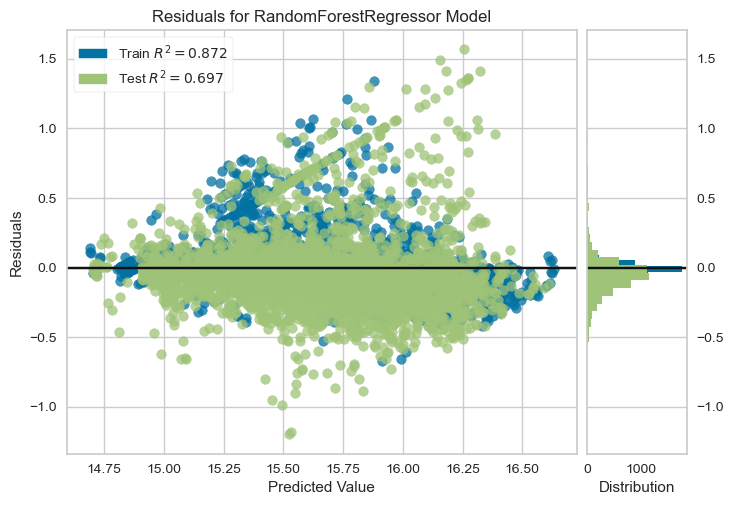

Mean Squared Error for split [1] (Test): 0.04686390262192893
Mean Squared Error for split [1] (Train): 0.019647504037300503
----------------------------------------------------------------------------
Mean Absolute Error for split [1] (Test): 0.1383270621831281
Mean Absolute Error for split [1] (Train): 0.07587590334908163




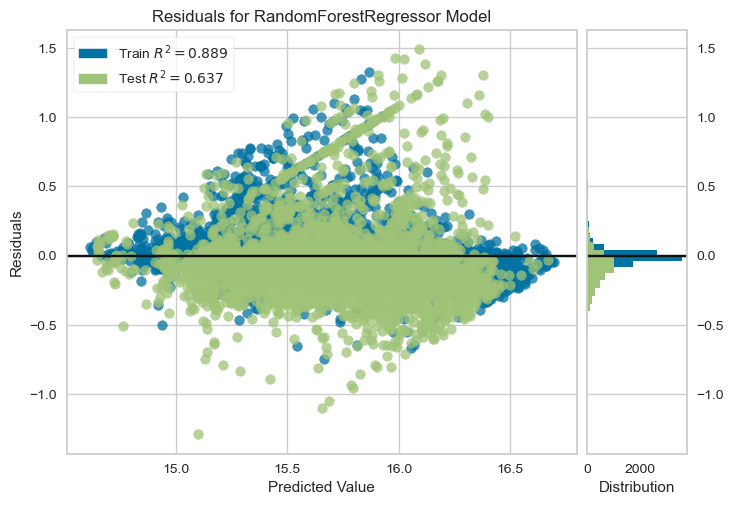

Mean Squared Error for split [2] (Test): 0.057266500555688576
Mean Squared Error for split [2] (Train): 0.017196031797454717
----------------------------------------------------------------------------
Mean Absolute Error for split [2] (Test): 0.1614941709752902
Mean Absolute Error for split [2] (Train): 0.06885716666787156




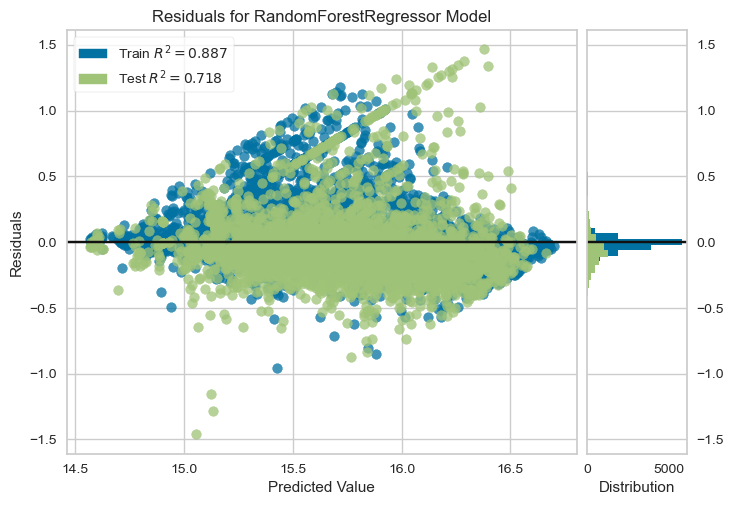

Mean Squared Error for split [3] (Test): 0.046629195431528374
Mean Squared Error for split [3] (Train): 0.017765129066147085
----------------------------------------------------------------------------
Mean Absolute Error for split [3] (Test): 0.14437145277372493
Mean Absolute Error for split [3] (Train): 0.07016748027307101




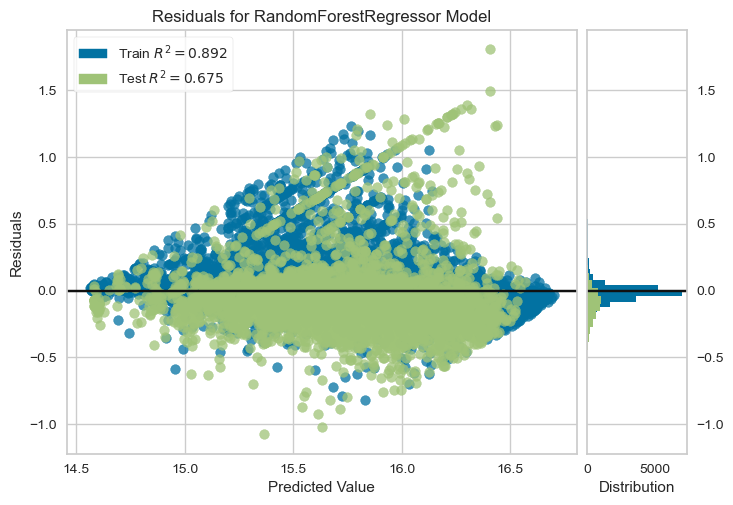

Mean Squared Error for split [4] (Test): 0.055406702971025304
Mean Squared Error for split [4] (Train): 0.017381695388771205
----------------------------------------------------------------------------
Mean Absolute Error for split [4] (Test): 0.16027032148064324
Mean Absolute Error for split [4] (Train): 0.06925221136778026




In [45]:
tscv = TimeSeriesSplit(n_splits=4)

rf_model_RandomizedSearchCV = RandomForestRegressor(
    n_estimators=200,  
    max_depth=None,    
    min_samples_split=2,  
    min_samples_leaf=5,   
    random_state=42   
)

print("Results with Tuned Model after RandomizedSearchCV:")

evaluate_model_train_and_test(rf_model_RandomizedSearchCV, data_attributes_scaled, data_target, tscv)

After performing RandomizedSearchCV, I observed that the model still suffers from overfitting. This suggests that the number of estimators (n_estimators) and the tree depth (max_depth) may be too large for the data. While these parameters were optimized to improve performance, they seem to make the model too complex, leading to overfitting. Therefore, it's likely that reducing the number of estimators and limiting the depth of the trees would improve generalization and reduce overfitting.

In [50]:
with open('rf_model_tuned.pkl', 'wb') as f:
    pickle.dump(rf_model_tuned, f)

print("Model saved successfully!")

Model saved successfully!


## 2. XGBoost

In [71]:
xgb_model = XGBRegressor()

In [72]:
xgb_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [73]:
tscv = TimeSeriesSplit(n_splits=4)

Results with XGBoost Model:


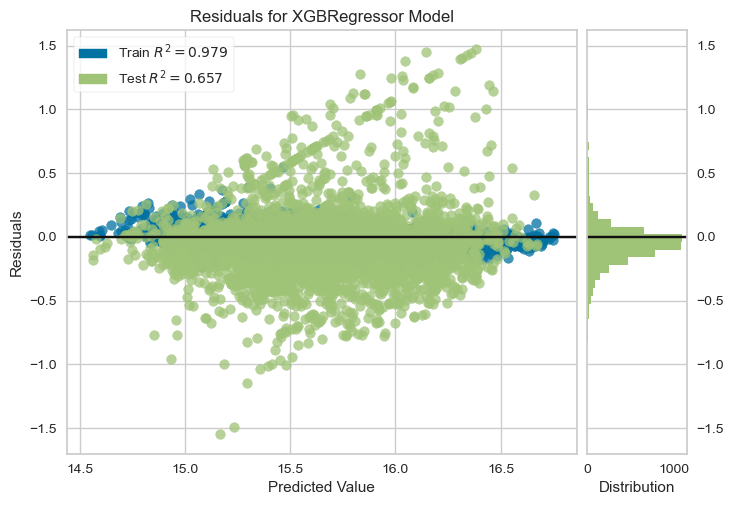

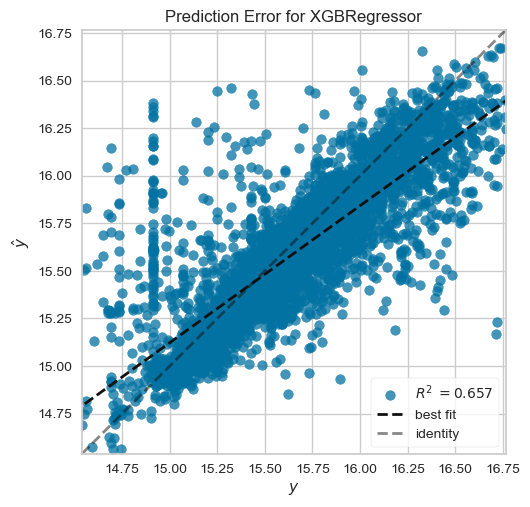

Mean Squared Error (MSE) for split [1]: 0.053022873046551164
Mean Absolute Error (MAE) for split [1]: 0.14750093030433126
----------------------------------------------------------


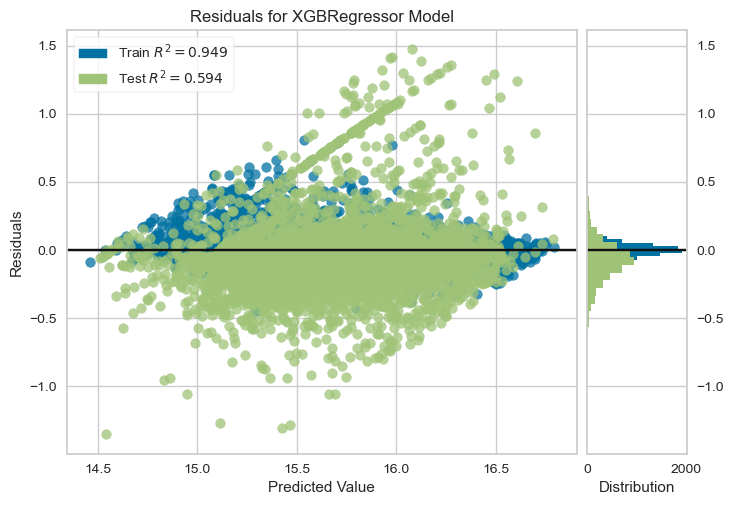

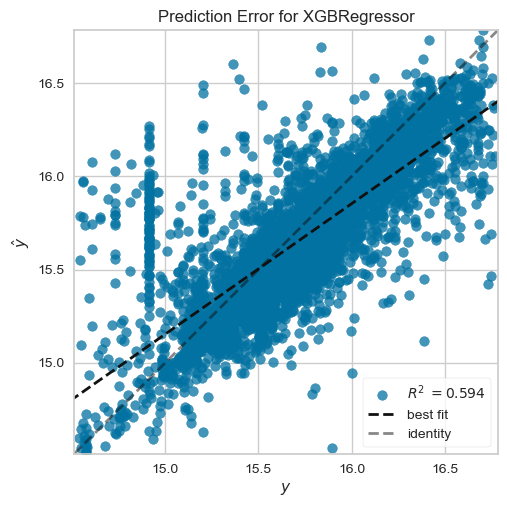

Mean Squared Error (MSE) for split [2]: 0.06393844372974512
Mean Absolute Error (MAE) for split [2]: 0.1688311473030644
----------------------------------------------------------


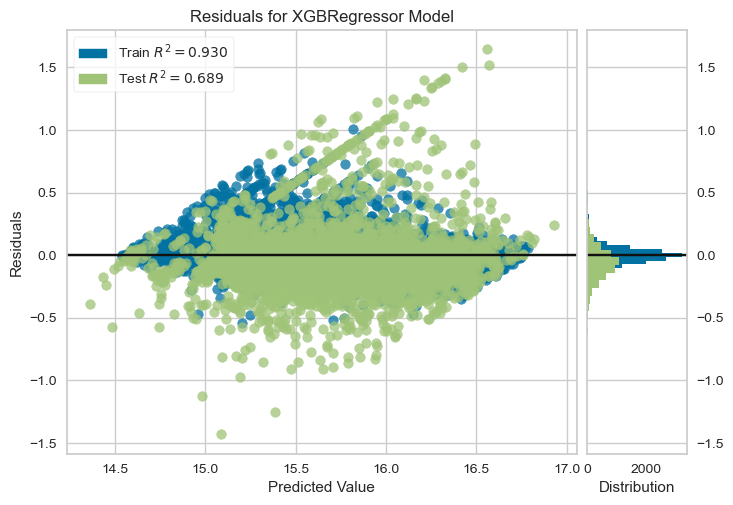

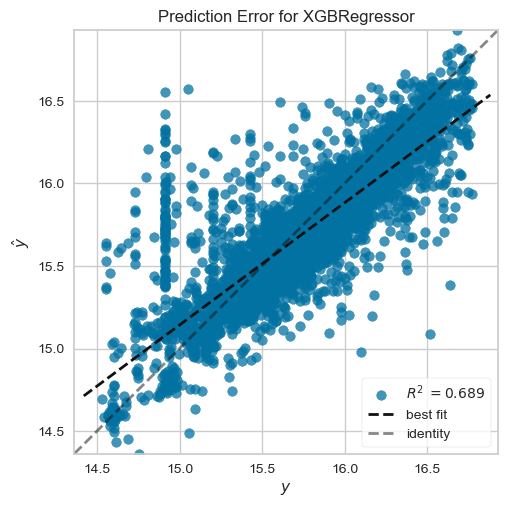

Mean Squared Error (MSE) for split [3]: 0.0515289488460388
Mean Absolute Error (MAE) for split [3]: 0.15000089455907598
----------------------------------------------------------


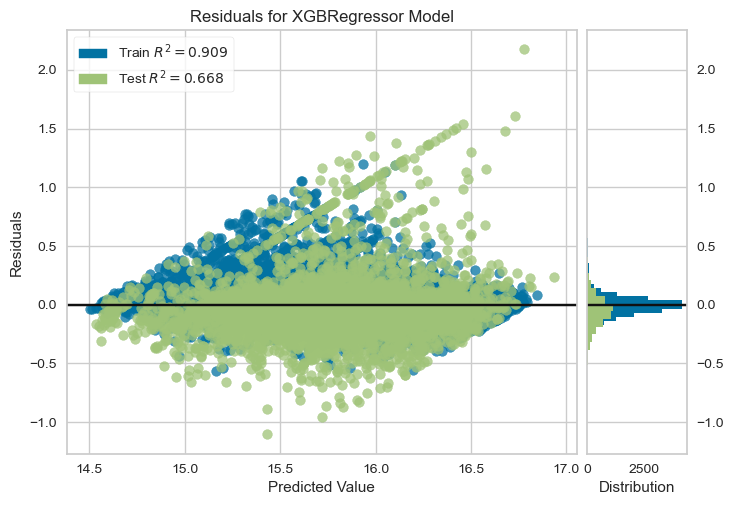

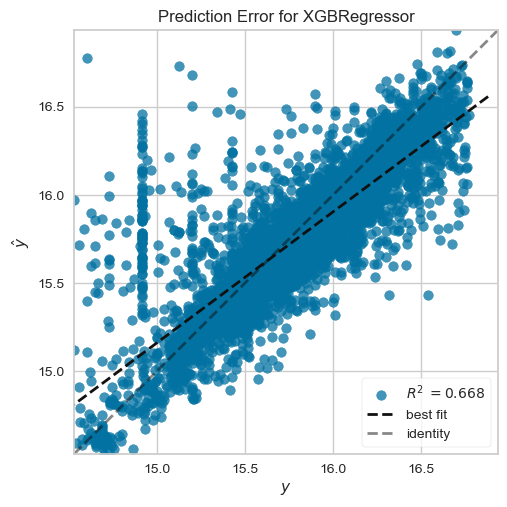

Mean Squared Error (MSE) for split [4]: 0.05665577787496116
Mean Absolute Error (MAE) for split [4]: 0.15200786471845312
----------------------------------------------------------


True Values  Predictions
0        15.856731    15.533234
1        14.845130    15.549663
2        15.964292    16.008923
3        15.152927    15.189512
4        15.978834    15.857183
...            ...          ...
22223    15.725135    15.835766
22224    15.816991    15.836910
22225    15.757264    15.521936
22226    16.418200    16.066074
22227    15.538277    15.662013

[22228 rows x 2 columns]

In [74]:
print("Results with Default XGBoost Model:")
evaluate_model_test_data(xgb_model, data_attributes_scaled, data_target, tscv)

The results for the default XGBoost Regressor look reasonably good, as the MSE and MAE values across the splits are fairly consistent and indicate relatively low error values. The MSE and MAE are consistent across all splits, suggesting that the model is performing uniformly on the time-series data and isn't overfitting significantly to one fold.

Now I should test the model for overfitting.

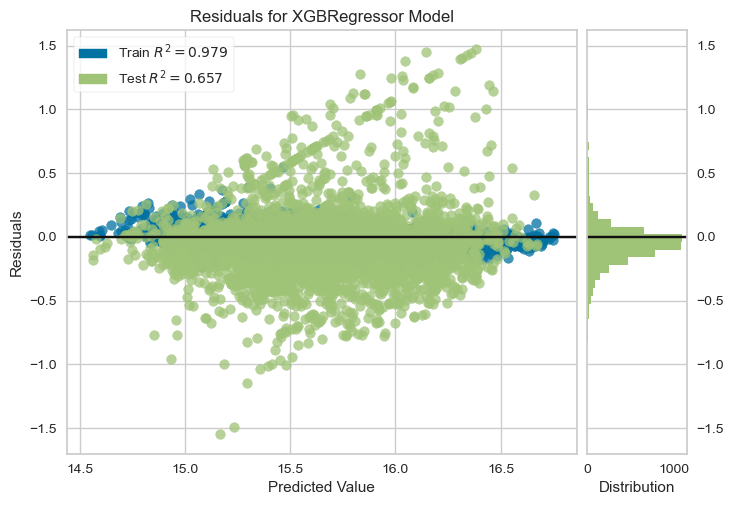

Mean Squared Error for split [1] (Test): 0.053022873046551164
Mean Squared Error for split [1] (Train): 0.0032924516961869953
----------------------------------------------------------------------------
Mean Absolute Error for split [1] (Test): 0.14750093030433126
Mean Absolute Error for split [1] (Train): 0.040694103875215513




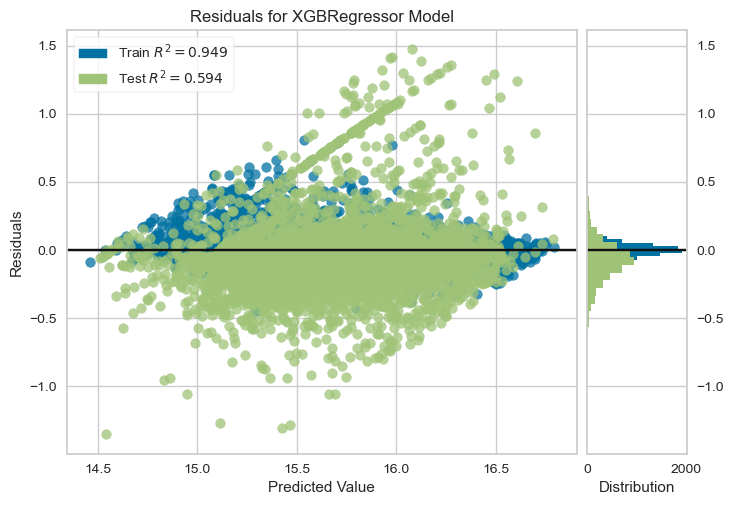

Mean Squared Error for split [2] (Test): 0.06393844372974512
Mean Squared Error for split [2] (Train): 0.007875269190383926
----------------------------------------------------------------------------
Mean Absolute Error for split [2] (Test): 0.1688311473030644
Mean Absolute Error for split [2] (Train): 0.05865262880152488




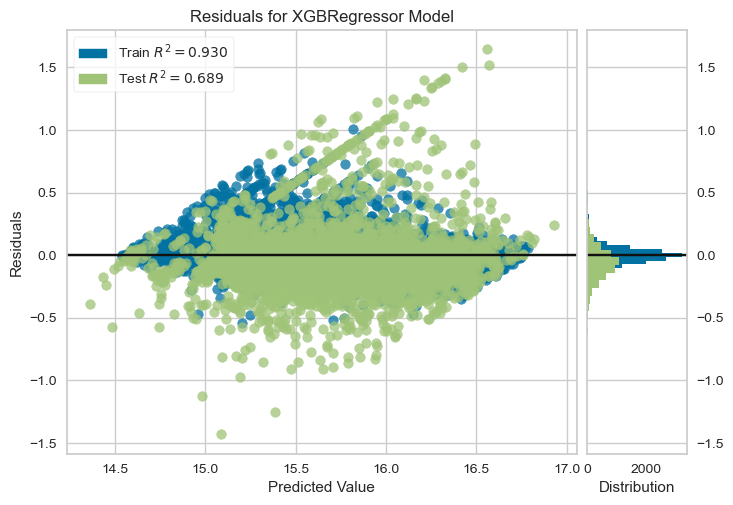

Mean Squared Error for split [3] (Test): 0.0515289488460388
Mean Squared Error for split [3] (Train): 0.011087490152085287
----------------------------------------------------------------------------
Mean Absolute Error for split [3] (Test): 0.15000089455907598
Mean Absolute Error for split [3] (Train): 0.06823198946097052




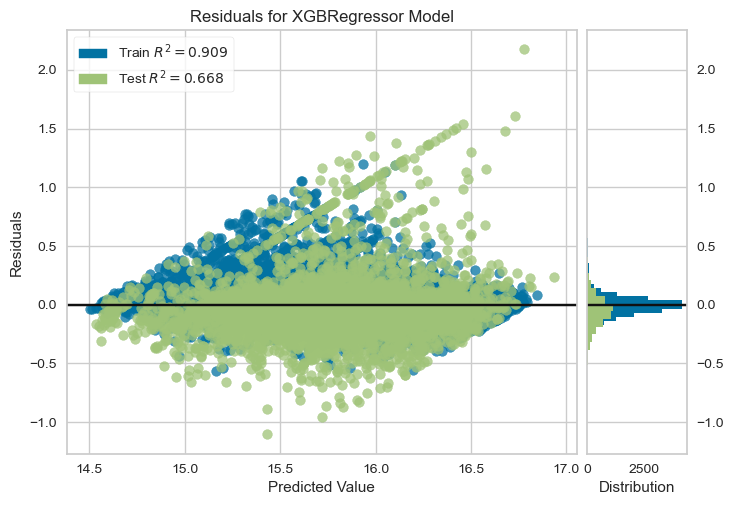

Mean Squared Error for split [4] (Test): 0.05665577787496116
Mean Squared Error for split [4] (Train): 0.014698170023400719
----------------------------------------------------------------------------
Mean Absolute Error for split [4] (Test): 0.15200786471845312
Mean Absolute Error for split [4] (Train): 0.07656455702779734




In [76]:
evaluate_model_train_and_test(xgb_model, data_attributes_scaled, data_target, tscv)

The results indicate potential overfitting! The MSE and MAE values on the train set are significantly lower than those on the test set.

I will add some hypermaters and test the tuned model again.

n_estimators=200
Брой дървета в модела (или итерации при буустинг).
Увеличен е до 200, за да компенсира по-ниската скорост на обучение (learning_rate), което позволява повече стъпки за оптимизация.

learning_rate=0.05
Скорост на обучение на модела.
По-бавната скорост на обучение означава, че всяко дърво прави по-малки корекции, което намалява риска от пренасочване и подобрява обобщаващата способност.

max_depth=5
Максимална дълбочина на дърветата.
По-плитките дървета (shallower trees) намаляват риска от пренасочване, като ограничават броя на разделенията и сложността на всеки индивидулен модел.

min_child_weight=5
Минимална сума от теглата на наблюденията в дъщерен възел.
Това предотвратява разделения, които водят до възли с твърде малко наблюдения или стойности с малка значимост, увеличавайки устойчивостта на модела.

gamma=1
Минимално намаление на загубата, необходимо за извършване на разделение.
Увеличаването на gamma прави модела по-консервативен, като се изисква по-значително намаление на грешката за извършване на ново разделение.

subsample=0.8
Процент от тренировъчните данни, които се използват за обучение на всяко дърво.
Това подобрява устойчивостта на модела чрез случайно вземане на 80% от данните за всяко дърво, което предотвратява пренасочване.

colsample_bytree=0.8
Процент от характеристиките, които се използват при обучение на всяко дърво.
Случайното използване на 80% от характеристиките за всяко дърво помага за намаляване на корелацията между дърветата и подобрява обобщаващата способност.

reg_alpha=0.5
L1 регуляризация (Lasso).
Това добавя наказание за броя на използваните характеристики, като намалява излишните и несъществени характеристики, което помага за намаляване на сложността на модела.

reg_lambda=1.0
L2 регуляризация (Ridge).
Това добавя наказание за големи стойности на теглата в модела, което намалява склонността към пренасочване и помага за поддържане на баланса.

random_state=42
Фиксиране на случайността за възпроизводимост.
Задава начална стойност на генератора на случайни числа, така че резултатите да са възпроизводими при различни изпълнения на модела.

Results with Tuned XGBoost Model:


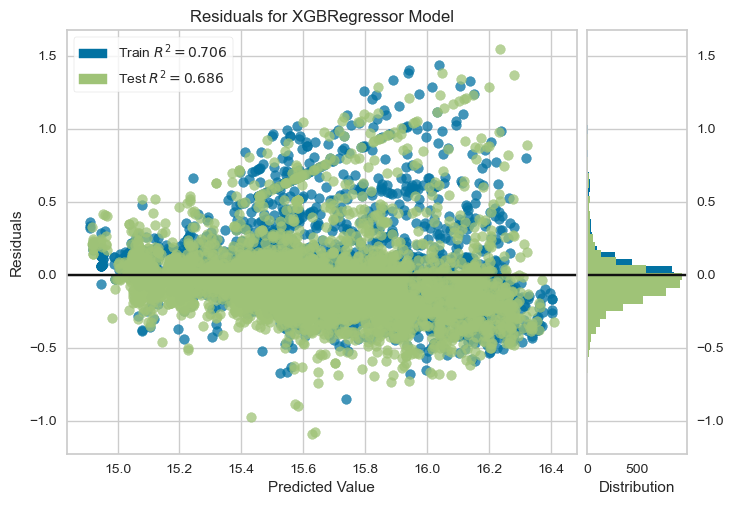

Mean Squared Error for split [1] (Test): 0.048537308645742905
Mean Squared Error for split [1] (Train): 0.045318534866661035
----------------------------------------------------------------------------
Mean Absolute Error for split [1] (Test): 0.14687895183114233
Mean Absolute Error for split [1] (Train): 0.13292759918832775




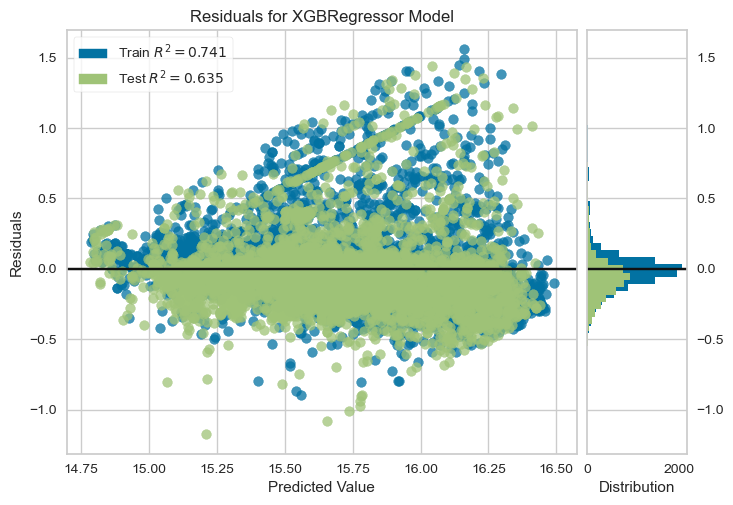

Mean Squared Error for split [2] (Test): 0.057495544761304196
Mean Squared Error for split [2] (Train): 0.040035715814629426
----------------------------------------------------------------------------
Mean Absolute Error for split [2] (Test): 0.16011017160342494
Mean Absolute Error for split [2] (Train): 0.1208169334946749




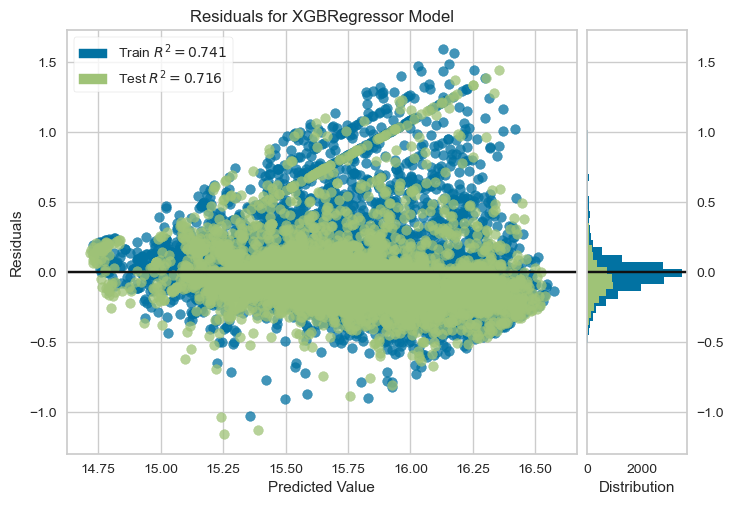

Mean Squared Error for split [3] (Test): 0.04705504688371084
Mean Squared Error for split [3] (Train): 0.0408744520121838
----------------------------------------------------------------------------
Mean Absolute Error for split [3] (Test): 0.14617774031597536
Mean Absolute Error for split [3] (Train): 0.12088514631202238




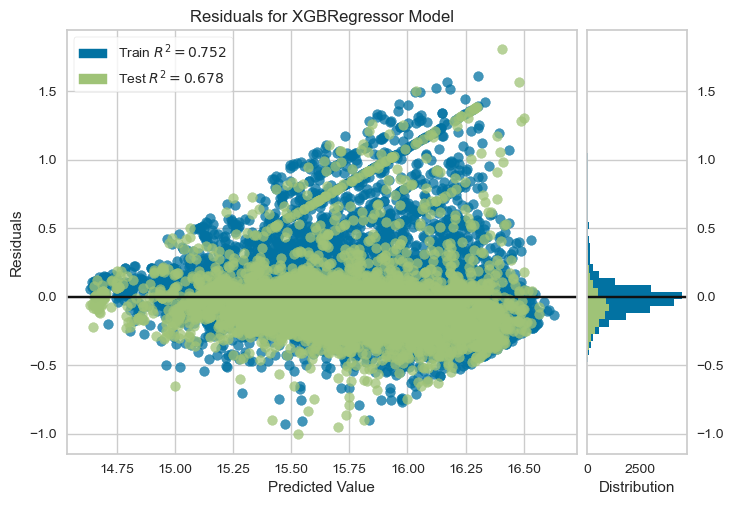

Mean Squared Error for split [4] (Test): 0.0548996090776219
Mean Squared Error for split [4] (Train): 0.03984832341344218
----------------------------------------------------------------------------
Mean Absolute Error for split [4] (Test): 0.15590379582663824
Mean Absolute Error for split [4] (Train): 0.11878167191004482




In [77]:
xgb_model_tuned = XGBRegressor(
    n_estimators=200,       # Increased to compensate for reduced learning rate
    learning_rate=0.05,     # Slower learning rate
    max_depth=5,            # Shallower trees to prevent overfitting
    min_child_weight=5,     # Minimum sum of weights for child nodes
    gamma=1,                # Minimum loss reduction for a split
    subsample=0.8,          # Randomly sample 80% of data per tree
    colsample_bytree=0.8,   # Randomly sample 80% of features per tree
    reg_alpha=0.5,          # L1 regularization to reduce feature redundancy
    reg_lambda=1.0,         # L2 regularization to reduce model complexity
    random_state=42
)

tscv = TimeSeriesSplit(n_splits=4)

print("Results with Tuned XGBoost Model:")
evaluate_model_train_and_test(xgb_model_tuned, data_attributes_scaled, data_target, tscv)

The tuned XGBoost model shows a significant improvement in performance, with a noticeable reduction in overfitting compared to the default model.

The gap between training and test errors (MSE and MAE) has narrowed significantly:

For instance, in Split 1, the Test MSE is 0.0485, and the Train MSE is 0.0453, indicating that the model is now generalizing better to unseen data. This trend holds consistently across all splits.
Compared to the default model, where the training error was orders of magnitude smaller than the test error, this tuning effectively addressed overfitting.

The Mean Squared Error (MSE) on the test sets across splits remains consistently low, with values between 0.0471 and 0.0575, showcasing stability and reliability in predictions across different folds.
The Mean Absolute Error (MAE) values (between 0.1461 and 0.1601) indicate the model's robustness in minimizing large prediction errors, which is vital for real-world applications.

Despite the improvement as the next step will use RandomSearchCV.

In [80]:
param_grid = {
    'n_estimators': [100, 200, 300, 500, 800],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.5, 1, 1.5, 2]
}

In [81]:
xgb_model = XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50, 
    scoring='neg_mean_squared_error',  
    cv=4,  
    verbose=2,
    random_state=42,
    n_jobs=-1 
)

In [82]:
random_search.fit(data_attributes_scaled, data_target)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", -random_search.best_score_)  # Convert from negative MSE to positive

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Best Parameters: {'subsample': 0.9, 'reg_lambda': 0.5, 'reg_alpha': 1, 'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Best Score: 0.04680476412858192


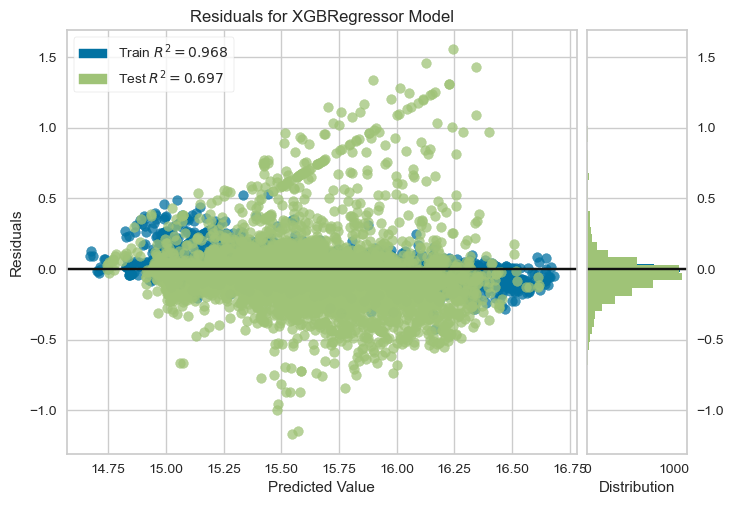

Mean Squared Error for split [1] (Test): 0.046786849677398934
Mean Squared Error for split [1] (Train): 0.004861215765609565
----------------------------------------------------------------------------
Mean Absolute Error for split [1] (Test): 0.13693294576156953
Mean Absolute Error for split [1] (Train): 0.04381469493538977




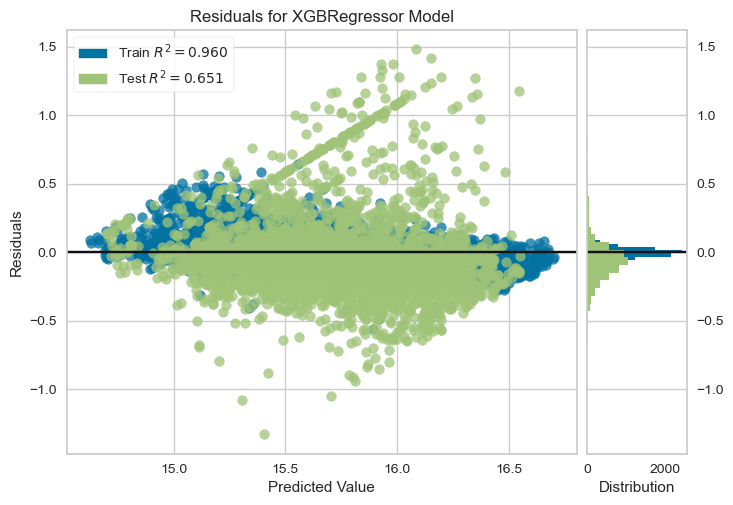

Mean Squared Error for split [2] (Test): 0.05497679475664703
Mean Squared Error for split [2] (Train): 0.0062076651548325715
----------------------------------------------------------------------------
Mean Absolute Error for split [2] (Test): 0.15362195869413278
Mean Absolute Error for split [2] (Train): 0.04887865233429082




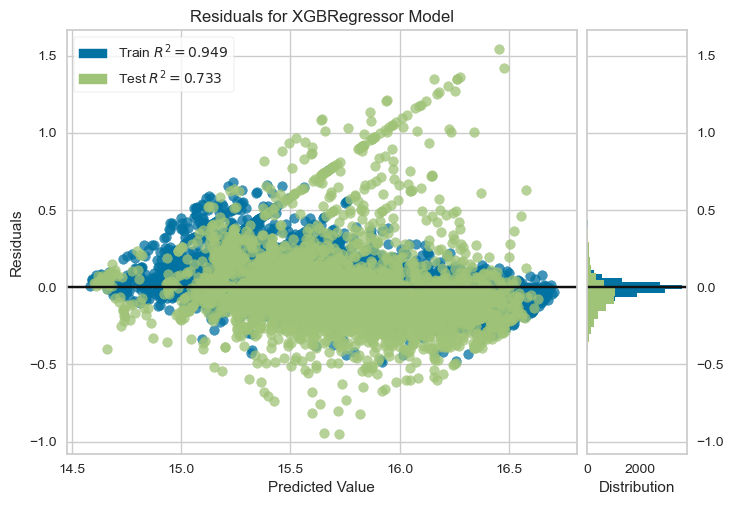

Mean Squared Error for split [3] (Test): 0.04422959146911456
Mean Squared Error for split [3] (Train): 0.008037930407066182
----------------------------------------------------------------------------
Mean Absolute Error for split [3] (Test): 0.13658282896742147
Mean Absolute Error for split [3] (Train): 0.05438033320001394




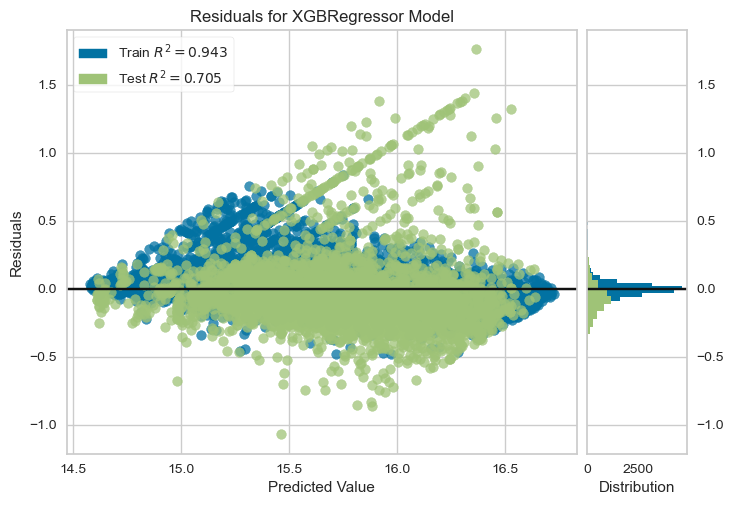

Mean Squared Error for split [4] (Test): 0.05020785598478506
Mean Squared Error for split [4] (Train): 0.009195964538876021
----------------------------------------------------------------------------
Mean Absolute Error for split [4] (Test): 0.14656654321013524
Mean Absolute Error for split [4] (Train): 0.057534874595004455




In [83]:
best_xgb_model = random_search.best_estimator_

evaluate_model_train_and_test(best_xgb_model, data_attributes_scaled, data_target, tscv)

The observed overfitting indicates that the model has become too powerful and overly tuned to the training data. Reasons for the overfitting are:
max_depth=10: A deeper tree enables the model to capture highly detailed patterns in the training data, increasing the risk of overfitting.
n_estimators=800: A large number of boosting iterations can refine the model to fit even the noise in the data.
Insufficient Regularization - reg_lambda=0.5 (L2 regularization) and reg_alpha=1 (L1 regularization) are present but might not be strong enough given the model's high complexity.


Results with Tuned XGBoost Model:


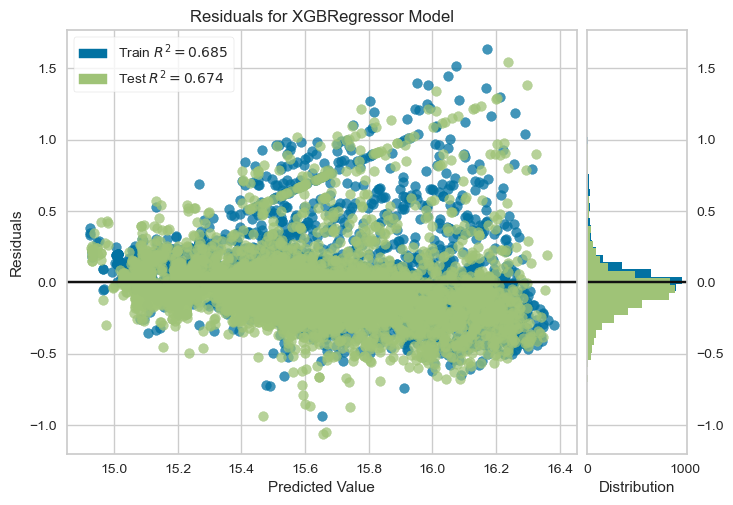

Mean Squared Error for split [1] (Test): 0.05034565804086982
Mean Squared Error for split [1] (Train): 0.04851734918572932
----------------------------------------------------------------------------
Mean Absolute Error for split [1] (Test): 0.1502222087188771
Mean Absolute Error for split [1] (Train): 0.13853316228130985




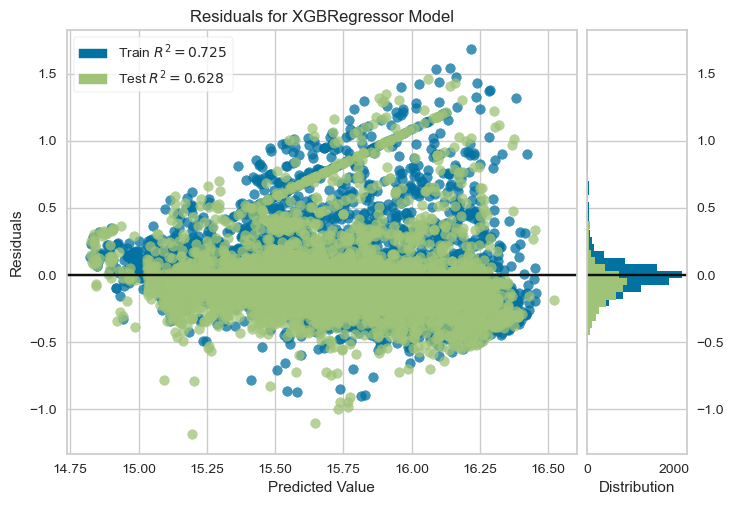

Mean Squared Error for split [2] (Test): 0.0586109147083522
Mean Squared Error for split [2] (Train): 0.042464299884321315
----------------------------------------------------------------------------
Mean Absolute Error for split [2] (Test): 0.16413162545151044
Mean Absolute Error for split [2] (Train): 0.12560637663049923




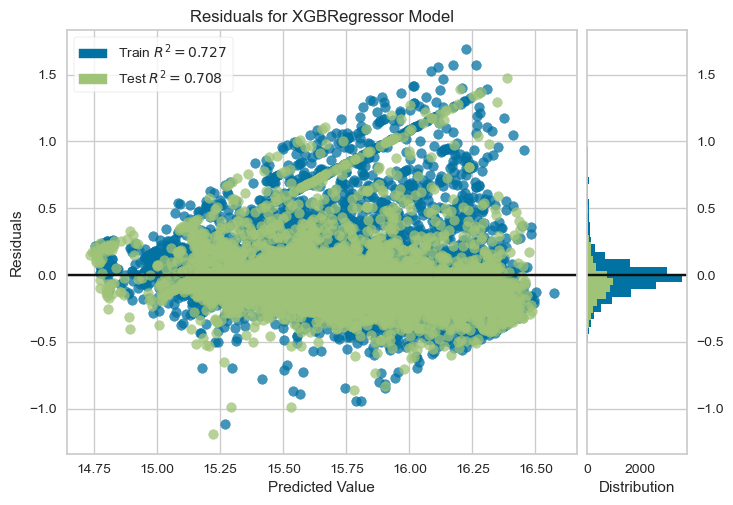

Mean Squared Error for split [3] (Test): 0.048307478420697166
Mean Squared Error for split [3] (Train): 0.04299574170833074
----------------------------------------------------------------------------
Mean Absolute Error for split [3] (Test): 0.14877319235610814
Mean Absolute Error for split [3] (Train): 0.12446107542637716




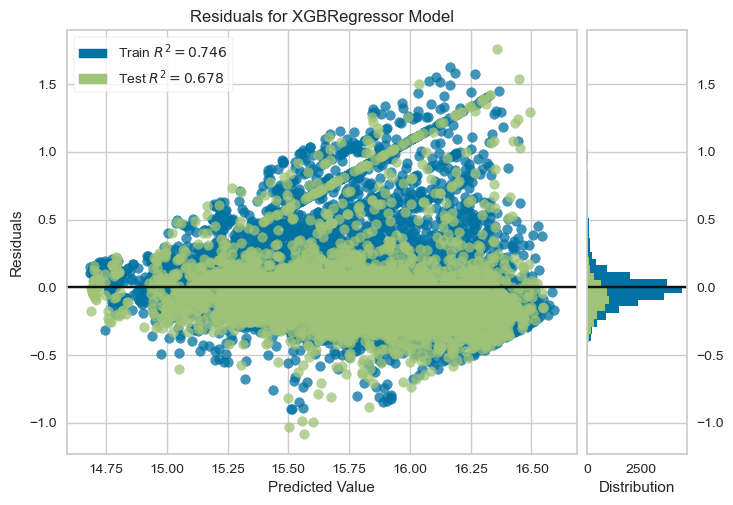

Mean Squared Error for split [4] (Test): 0.05480904399176425
Mean Squared Error for split [4] (Train): 0.04090782170467434
----------------------------------------------------------------------------
Mean Absolute Error for split [4] (Test): 0.15514309920769176
Mean Absolute Error for split [4] (Train): 0.12107835539842053




In [85]:
xgb_reg = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.7,
    colsample_bytree=0.5,
    reg_alpha=2,
    reg_lambda=2,
    gamma=1,
    min_child_weight=5,
    random_state=42
)

print("Results with Tuned XGBoost Model:")
evaluate_model_train_and_test(xgb_reg, data_attributes_scaled, data_target, tscv)

The tuned XGBoost model shows significant improvement over previous iterations, with a clear reduction in overfitting. The training and test errors are now closer together, indicating better generalization. For example, in Split [1], the test MSE is 0.0503, and the train MSE is 0.0485, with test MAE at 0.1502 and train MAE at 0.1385. The test MSE across all splits ranges from 0.0483 to 0.0586, showing more stable performance. While the model has improved, there is still room for further enhancement, particularly through feature engineering or hyperparameter refinement. Overall, the model is now well-balanced, providing reliable predictions with reduced overfitting, making it ready for further analysis or deployment.

After that step I should compare the results from the first tuned XGboost model and this one so, I can decide which one is better option.

So, let's compare:
1. Test MSE:
The first set has slightly lower test MSE values (0.0485 to 0.0575) compared to the second set (0.0503 to 0.0586). Lower test MSE suggests better performance on unseen data.

2. Train MSE:
The second set has lower train MSE (0.0398 to 0.0485) compared to the first set (0.0400 to 0.0453), indicating slightly better training performance.

3. Test MAE:
The first set has a lower test MAE range (0.1468 to 0.1601) compared to the second set (0.1502 to 0.1641), suggesting that the first set has better average error on the test set.

4. Train MAE:
The first set has lower train MAE (0.1208 to 0.1329) compared to the second set (0.1211 to 0.1385).

The first set of results seems to perform better overall, as it has slightly lower test MSE and test MAE, which are more important for evaluating generalization to unseen data. The second set has a slightly better performance on the train data, but it doesn't translate to better generalization. Therefore, the first results are the better ones in terms of model performance on unseen data.

Now, I will save the model. 

In [89]:
with open('xgb_model_tuned.pkl', 'wb') as f:
    pickle.dump(xgb_model_tuned, f)

print("Model saved successfully!")

Model saved successfully!


## 3. AdaBoost

I will continnue with AdaBoost - a powerful ensemble learning method that combines weak learners (usually decision trees) to form a strong learner.

In [91]:
ada_model = AdaBoostRegressor()

Results with Default AdaBoost Model:


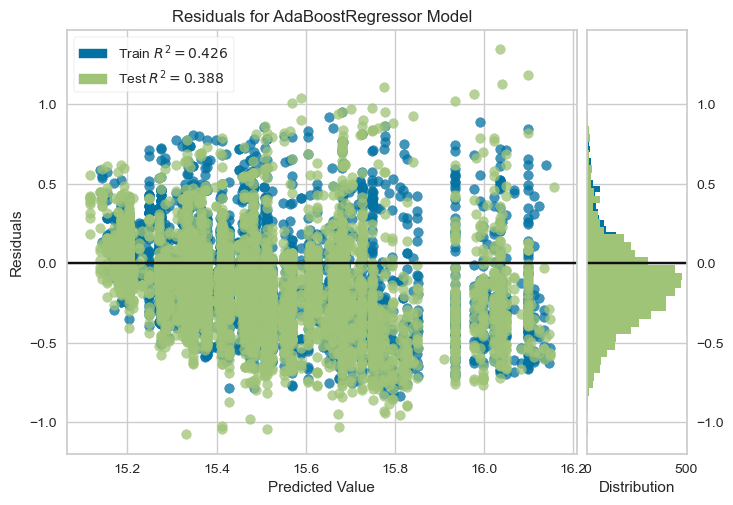

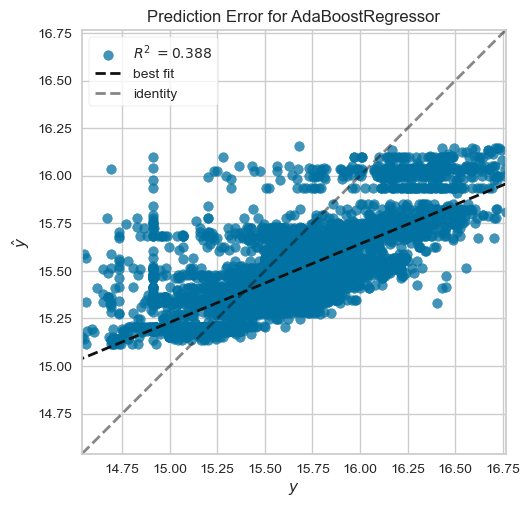

Mean Squared Error (MSE) for split [1]: 0.09450769817287066
Mean Absolute Error (MAE) for split [1]: 0.2419159759028793
----------------------------------------------------------


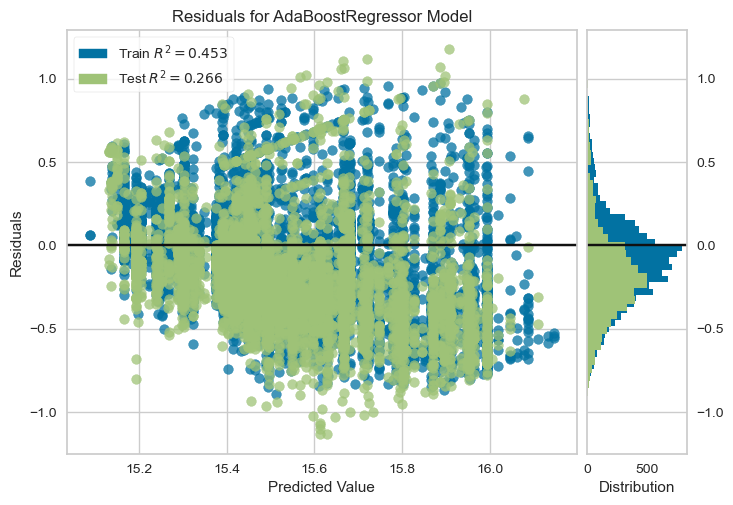

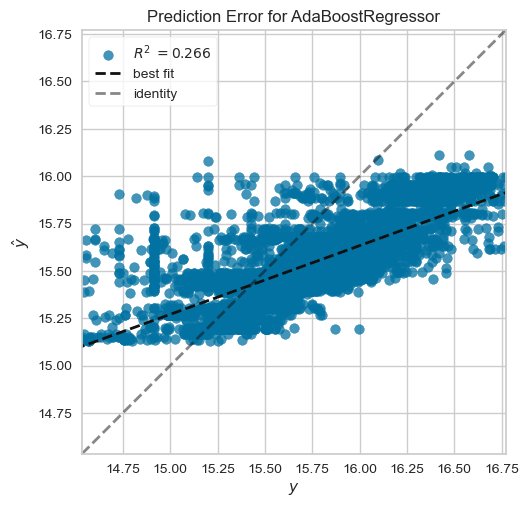

Mean Squared Error (MSE) for split [2]: 0.11565947987572638
Mean Absolute Error (MAE) for split [2]: 0.27653276685503403
----------------------------------------------------------


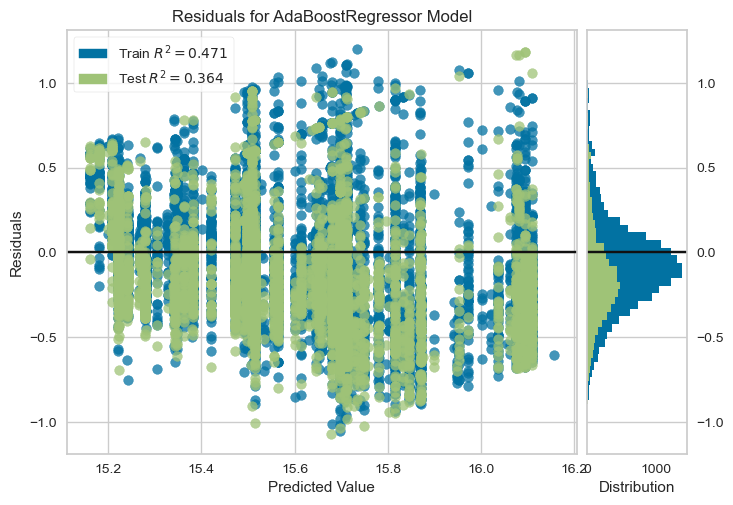

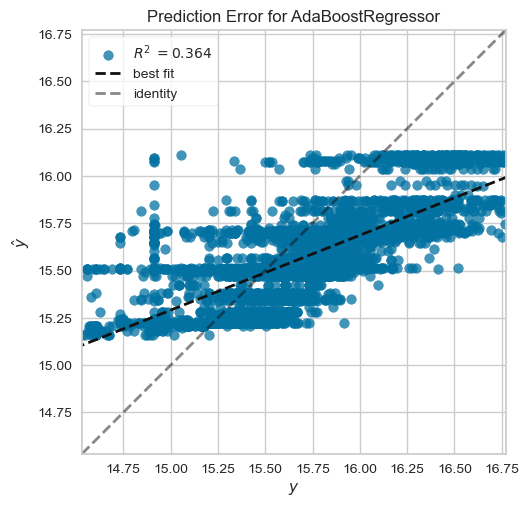

Mean Squared Error (MSE) for split [3]: 0.1052873477346577
Mean Absolute Error (MAE) for split [3]: 0.26273827155213897
----------------------------------------------------------


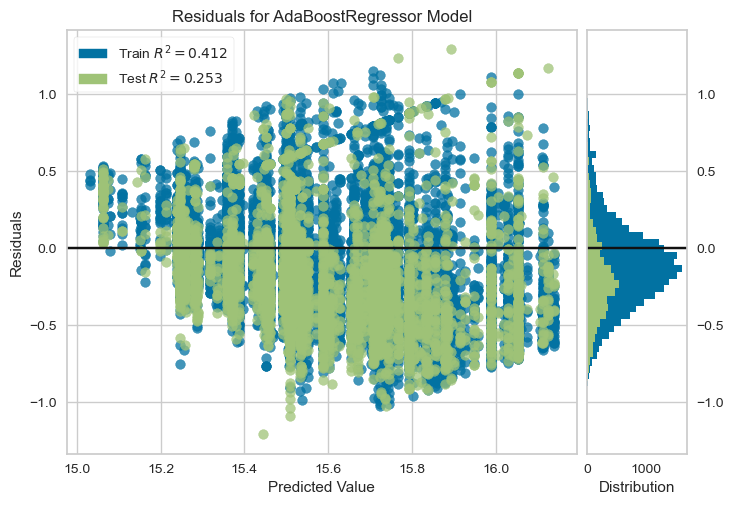

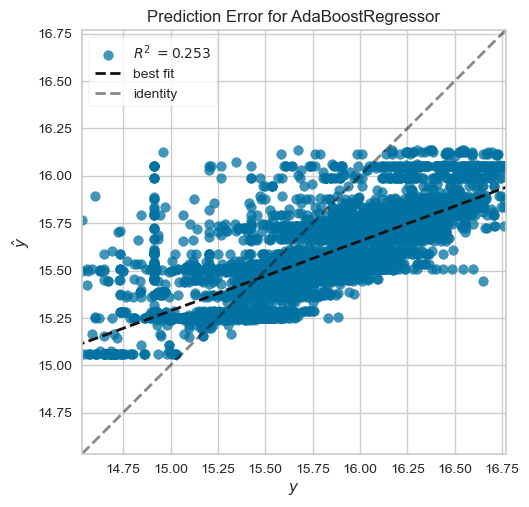

Mean Squared Error (MSE) for split [4]: 0.12740598010128582
Mean Absolute Error (MAE) for split [4]: 0.29603783499485226
----------------------------------------------------------


True Values  Predictions
0        15.856731    15.463617
1        14.845130    15.509952
2        15.964292    15.509952
3        15.152927    15.192281
4        15.978834    15.682867
...            ...          ...
22223    15.725135    15.705586
22224    15.816991    15.508464
22225    15.757264    15.285575
22226    16.418200    15.737131
22227    15.538277    15.498259

[22228 rows x 2 columns]

In [92]:
print("Results with Default AdaBoost Model:")
evaluate_model_test_data(ada_model, data_attributes_scaled, data_target, tscv)

Let's compare the results from the XGBoost default model and the AdaBoost default model: 

**Conclusions from AdaBoost Results**:
1. Higher Error Metrics: The MSE and MAE values for AdaBoost are relatively high compared to the default XGBoost results you provided earlier. The errors seem to increase progressively across the splits, with Split 4 showing the highest errors.
2. Variance in Results: There is noticeable variance across the folds, which could indicate that AdaBoost is more sensitive to the specific train-test splits in this case. This might suggest that AdaBoost is more affected by noise in the data or that it struggles with the complexity of the dataset.
3. Underperformance Relative to XGBoost: The errors are generally larger than those seen with XGBoost, both in terms of MSE and MAE. This could suggest that XGBoost might be a better model for this particular dataset, as it tends to perform well in more complex regression problems.

**Comparing with XGBoost Default Model**:
1. XGBoost is outperforming AdaBoost: Based on the MSE and MAE metrics, XGBoost is providing more accurate predictions than AdaBoost in this case. It shows lower error rates and less variability across the folds, which is likely due to its ability to handle complex data patterns and its built-in regularization features.

2. AdaBoost Struggles with the Dataset: AdaBoost seems to be overfitting or struggling to generalize well to the dataset, as seen by the higher error rates. This is not uncommon, as AdaBoost can sometimes overfit, especially when the base learners (usually shallow trees) are not regularized adequately.

I will now try some hyperparameters.

In [101]:
ada_boost_model_tuned = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=3),
    n_estimators=200,
    learning_rate=0.01,
    loss='exponential',
    random_state=42
)

Results with AdaBoost Model:


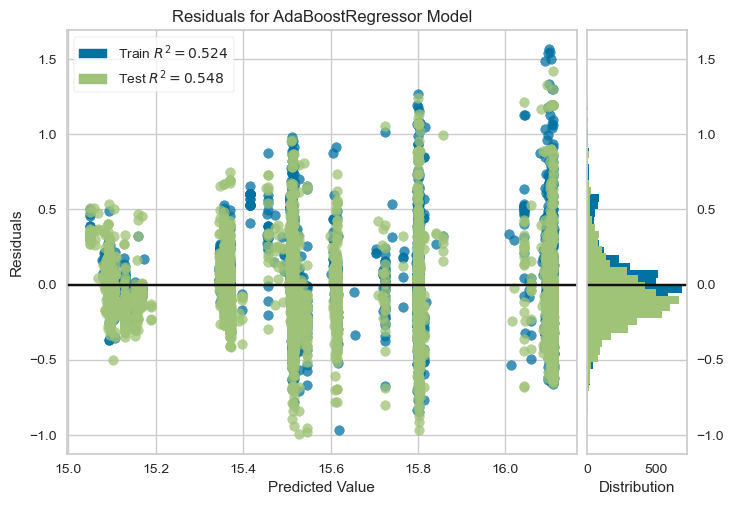

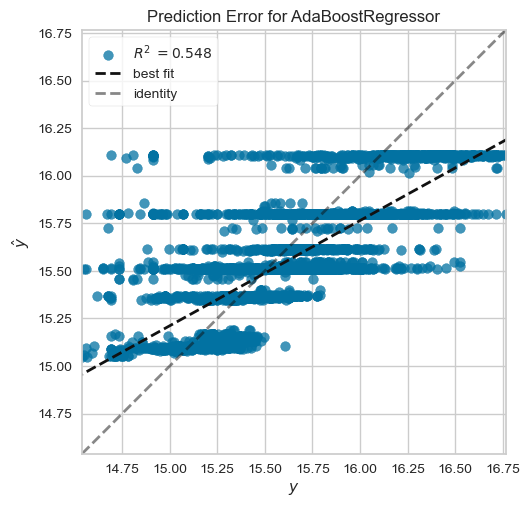

Mean Squared Error (MSE) for split [1]: 0.06978937762208884
Mean Absolute Error (MAE) for split [1]: 0.19866734135210196
----------------------------------------------------------


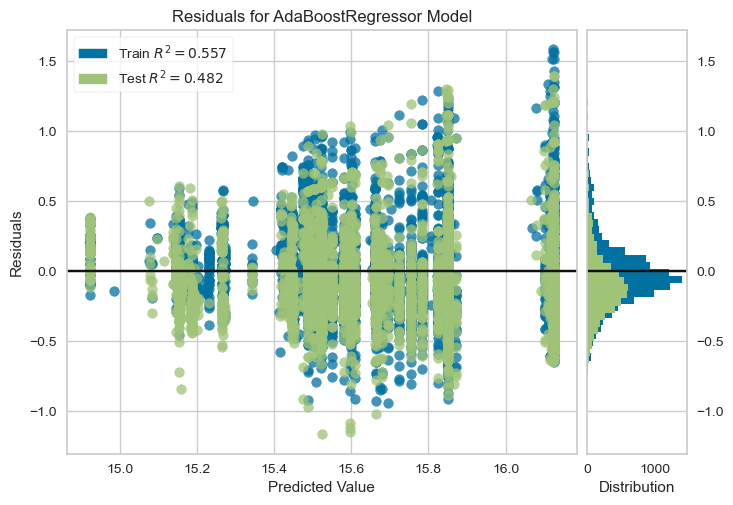

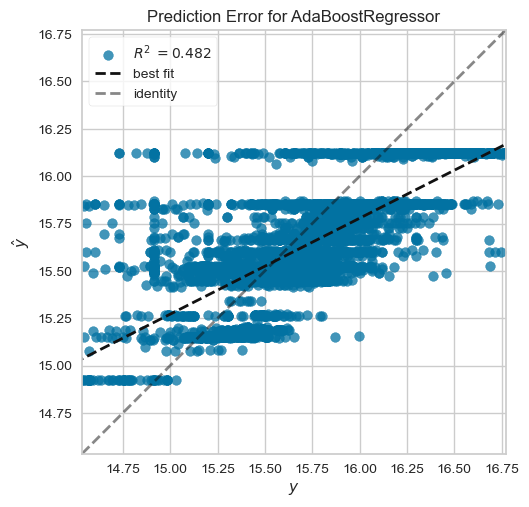

Mean Squared Error (MSE) for split [2]: 0.08160775905400688
Mean Absolute Error (MAE) for split [2]: 0.21644058735808813
----------------------------------------------------------


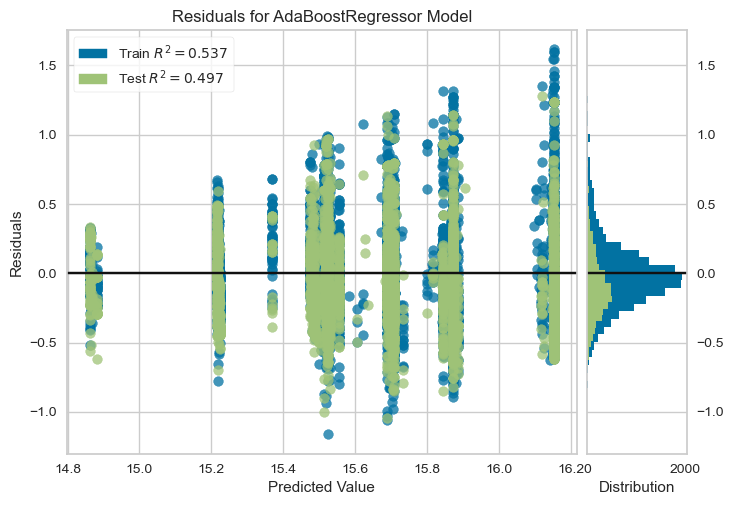

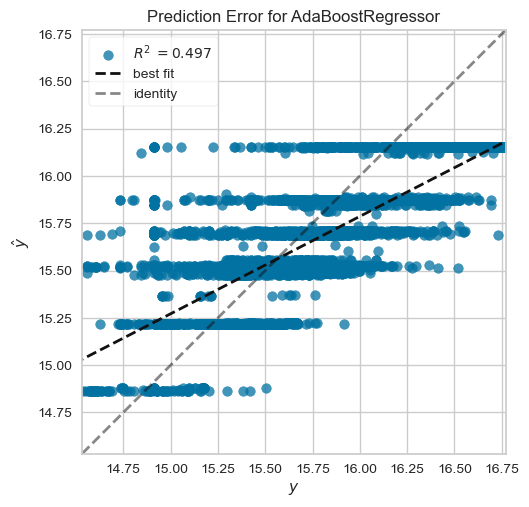

Mean Squared Error (MSE) for split [3]: 0.08327113650550642
Mean Absolute Error (MAE) for split [3]: 0.22613192284422512
----------------------------------------------------------


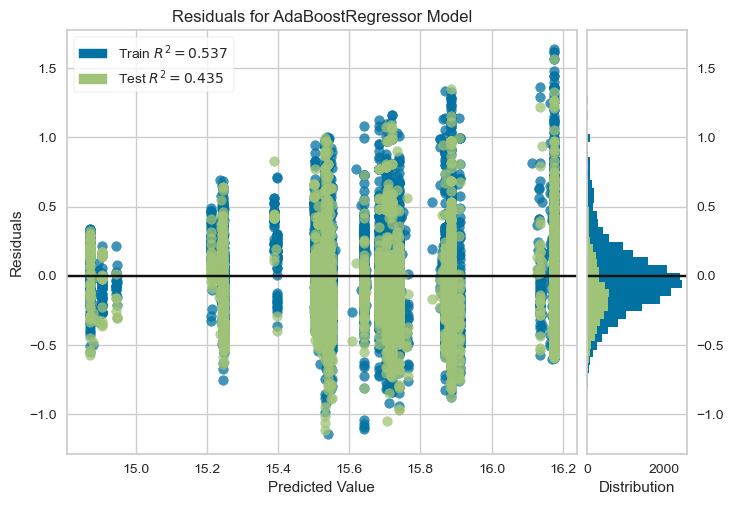

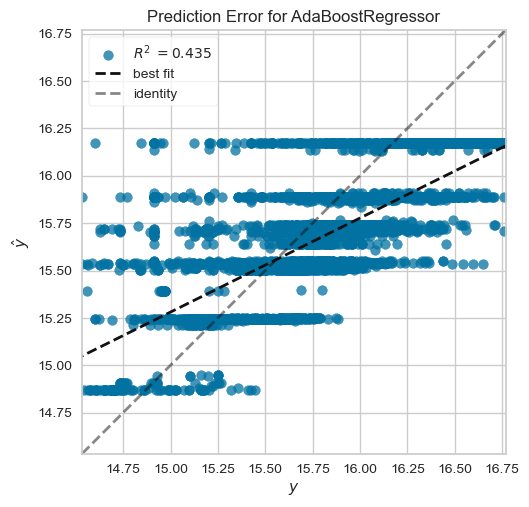

Mean Squared Error (MSE) for split [4]: 0.09639882641638751
Mean Absolute Error (MAE) for split [4]: 0.2434316063651895
----------------------------------------------------------


True Values  Predictions
0        15.856731    15.516702
1        14.845130    15.514567
2        15.964292    15.514567
3        15.152927    15.094930
4        15.978834    15.801600
...            ...          ...
22223    15.725135    15.719392
22224    15.816991    15.683346
22225    15.757264    15.244150
22226    16.418200    15.886202
22227    15.538277    15.641264

[22228 rows x 2 columns]

In [103]:
tscv = TimeSeriesSplit(n_splits=4)

print("Results with AdaBoost Model:")
evaluate_model_test_data(ada_boost_model_tuned, data_attributes_scaled, data_target, tscv)

In [104]:
base_estimator = DecisionTreeRegressor(max_depth=3, min_samples_split=10, min_samples_leaf=5)

In [105]:
ada_model_hyperparams = AdaBoostRegressor(estimator=base_estimator, learning_rate=0.05, n_estimators=200)

In [106]:
tscv = TimeSeriesSplit(n_splits=4)

Results with Tuned AdaBoost Model:


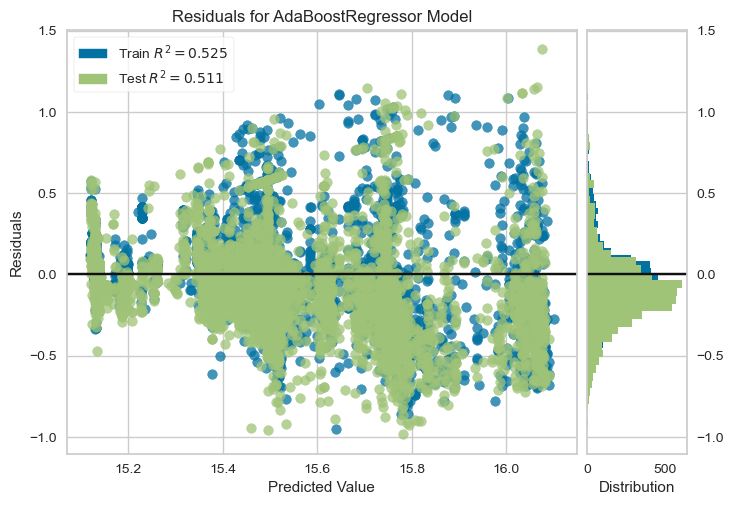

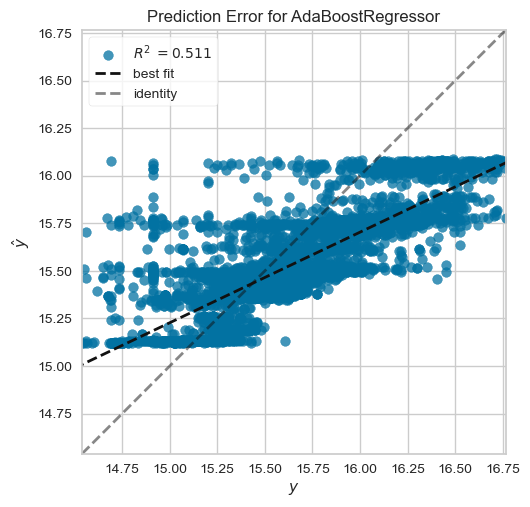

Mean Squared Error (MSE) for split [1]: 0.07557572281415469
Mean Absolute Error (MAE) for split [1]: 0.20807831117313536
----------------------------------------------------------


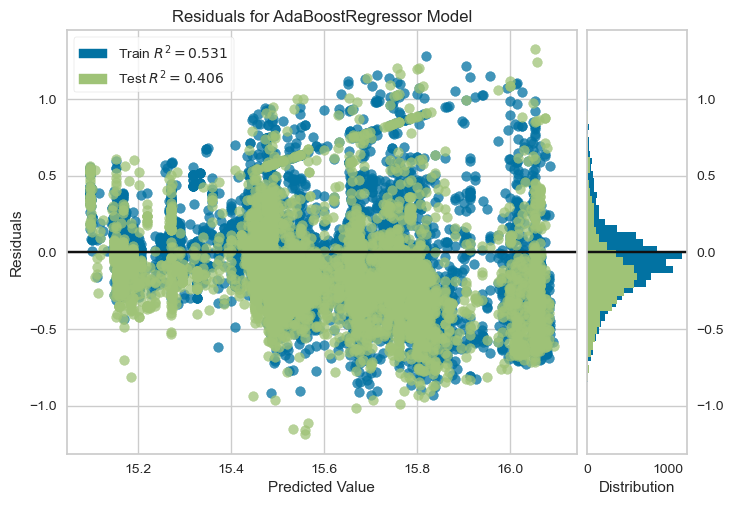

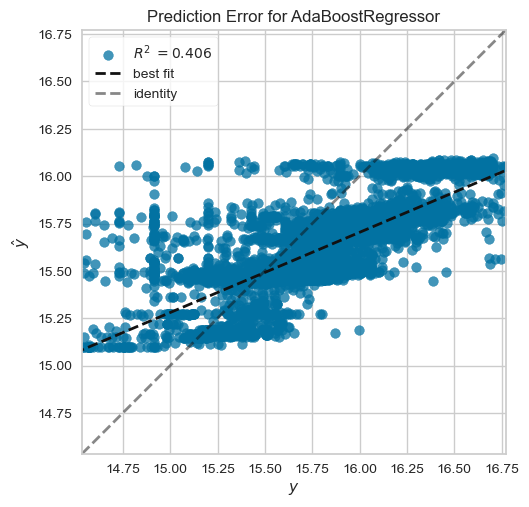

Mean Squared Error (MSE) for split [2]: 0.09363188056867196
Mean Absolute Error (MAE) for split [2]: 0.2411834334090436
----------------------------------------------------------


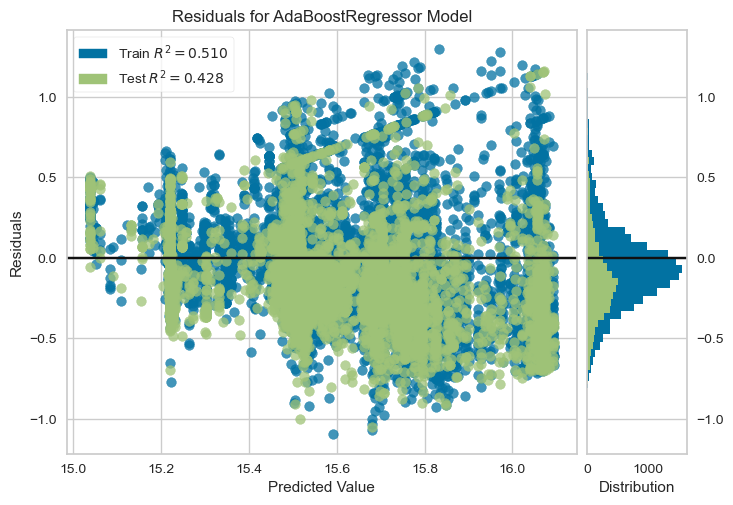

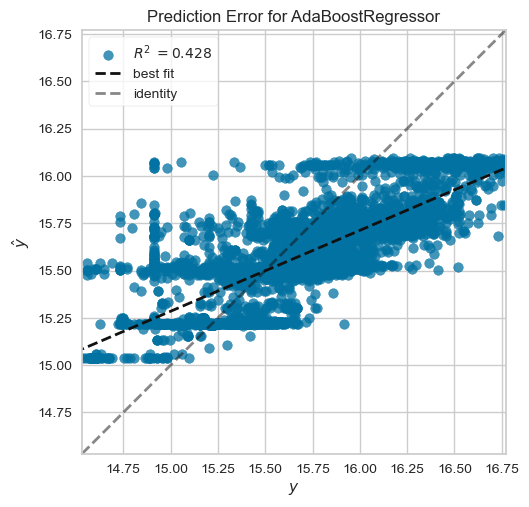

Mean Squared Error (MSE) for split [3]: 0.09476703909799446
Mean Absolute Error (MAE) for split [3]: 0.24947397397273224
----------------------------------------------------------


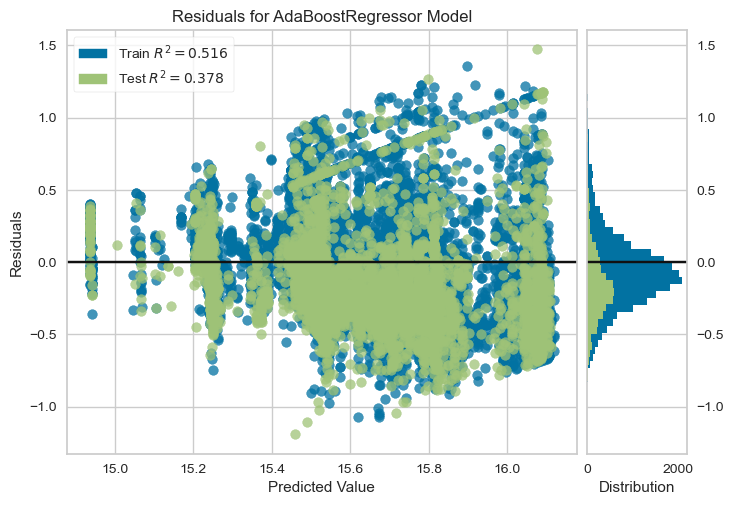

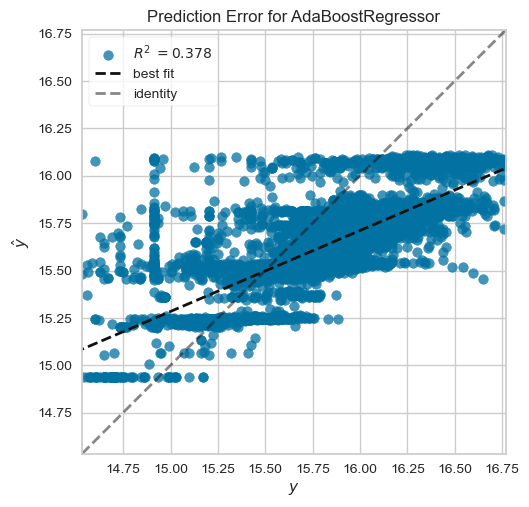

Mean Squared Error (MSE) for split [4]: 0.10605400110632952
Mean Absolute Error (MAE) for split [4]: 0.2641657041393441
----------------------------------------------------------


True Values  Predictions
0        15.856731    15.511673
1        14.845130    15.496204
2        15.964292    15.511310
3        15.152927    15.137730
4        15.978834    15.739729
...            ...          ...
22223    15.725135    15.698413
22224    15.816991    15.583212
22225    15.757264    15.250725
22226    16.418200    15.813293
22227    15.538277    15.545961

[22228 rows x 2 columns]

In [108]:
print("Results with Tuned AdaBoost Model:")
evaluate_model_test_data(ada_model_hyperparams, data_attributes_scaled, data_target, tscv)

Compared to the Random Forest and XGBoost I am not satisfied with the results of AdaBoost. 

So in general my two best models for now are `rf_model_tuned` and `xgb_model_tuned`. Now i will compare them to decide which one is the better option.

**XGBoost Model (Tuned) Performance:**

The XGBoost model demonstrates consistently better performance in terms of both Mean Squared Error (MSE) and Mean Absolute Error (MAE) across all four data splits. Specifically:

The MSE for XGBoost on the test data ranges from 0.0485 to 0.0575, which indicates relatively low prediction errors.
The MAE for XGBoost on the test data ranges from 0.1469 to 0.1601, reflecting that the model's predictions are relatively close to the actual values on average.

Additionally, the gap between training and testing errors in XGBoost is smaller compared to Random Forest, indicating better generalization and less overfitting. This suggests that XGBoost is able to make accurate predictions without memorizing the training data too much, thus performing well on unseen data.

**Random Forest Model (Tuned) Performance:**

In contrast, the Random Forest model shows higher errors across all metrics:

The MSE for Random Forest on the test data ranges from 0.0565 to 0.0739, which is consistently higher than XGBoost.
The MAE for Random Forest ranges from 0.1658 to 0.1987, indicating that the model’s predictions are further from the actual values compared to XGBoost.

While the Random Forest model does not exhibit large overfitting (the training and testing errors are close), the overall performance is worse compared to XGBoost. The model's errors are higher, and it doesn’t generalize as well to the test set.

**Conclusion:** 
After comparing both models, XGBoost clearly outperforms Random Forest in terms of prediction accuracy and generalization. XGBoost achieves lower MSE and MAE values, indicating that it provides more accurate and reliable predictions. Moreover, XGBoost shows better generalization, as evidenced by its smaller gap between training and testing errors. Therefore, if you're looking for a model that can consistently make accurate predictions and generalize well to unseen data, XGBoost would be the better choice between the two.

## Best model for now

So for now my best model is the `xgb_model_tuned` and i saved it.

## Project conclusion 

In this project, I developed machine learning models aimed at predicting property sale prices in Russia based on historical transaction data and macroeconomic indicators. Through a detailed process involving data preprocessing, exploratory analysis, feature engineering, and model evaluation, I was able to create a model that provides valuable insights into the housing market and accurately forecasts property prices.

Throughout the project, the `XGBoost` model emerged as one of the most reliable predictors, demonstrating strong performance in terms of accuracy and generalization. We also explored the potential of Random Forest models and AdaBoost, but found that fine-tuning hyperparameters for these models would require additional effort to achieve the same level of performance as XGBoost.

The success of this project is a testament to the importance of data quality, feature engineering, and model selection in building effective predictive systems. However, the task of accurately forecasting property prices remains complex, and there is always room for improvement. In future work, I plan to explore a broader range of machine learning models, such as neural networks, gradient boosting, and others, to compare their performance. Additionally, further hyperparameter tuning and more advanced techniques, such as ensemble methods or cross-validation, will be employed to refine the models.

The project serves as a foundation for continued exploration and improvement in predicting property prices. By expanding the model's scope and leveraging more sophisticated algorithms and techniques, the goal is to develop an even more robust, interpretable, and accurate model that can provide actionable insights for stakeholders in the housing market.